# Исследование алгоритмов для регулярных запросов

## Постановка задачи

Данный эксперимент посвящен исследованию следующих задач достижимости, решаемых в предыдущих работах.

- Достижимость между всеми парами вершин (`tensor_based_rpq`).
- Достижимость для каждой из заданного множества стартовых вершин (`ms_bfs_based_rpq`).

Вопросы, на которые необходимо ответить в ходе исследования.

- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?


## Описание исследуемых решений

Оба решения на вход принимают граф, его множество стартовых и финальных веришни, а также регулярное выражение, которому должны удолетворять пути.


### tensor_based_rpq (Достижимость между всеми парами вершин)

- Из полученного графа и регулярного выражения строим конечные автоматы.
- По полученным автоматам строим их булевы декомпозиции.
- Перемножаем получившиеся булевы декомпозиции с помощью тензорного произведения. 
	- Относительно автоматов этот шаг равносилен их пересечению.
- Объединяем все элементы получившейся булевой декомпозиции.
- Для получившейся матрицы строим транзитивное замыкание.
	- Это транзитивное замыкание отражает все возможные пути в пересечённом автомате.
- По транзитивному замыканию восстанавливаем достижимость вершин в изначальном графе (с учётом ограничения на пути).


### ms_bfs_based_rpq (Достижимость для каждой из заданного множества стартовых вершин)

- Из полученного графа и регулярного выражения строим конечные автоматы.
- По полученным автоматам строим их булевы декомпозиции.
- Создаем булеву декомпозицию для объединения автоматов, вычисляя прямое суммирование булевых декомпозиций предыдущих автоматов.
- Создаём фронт и маску посещенных состояний на основе стартовых состояний.
	- Фронт - это матрица отображающая состояния в которых мы находимся в данный момент.
- Выполняем основной цикл BFS:
    - Перемещаем фронт на основе булевой декомпозиции.
	    - Умножаем фронт на элементы булевой декомпозиции.
	    - Складываем и преобразовываем полившиеся матрицы для корректной дальнейшей работы.
    - Обновляем маску посещенных состояний, добавляя обработанные состояния.
		- А также с помощью маски убираем из фронта уже посещенные состояния.
    - Если маска не изменилась, выходим из цикла.
- По маске посещенных состояний восстанавливаем достижимость вершин в изначальном графе (с учётом ограничения на пути).

## Вспомогательное

In [26]:
import logging
import multiprocessing

# Отключение логирования, чтобы библиотека cfpq_data не отвлекала информационными сообщениями
logging.disable(logging.INFO)

# Число процессоров для параллельного запуска тестов
CPU_COUNT = min(6, multiprocessing.cpu_count())

## Описание набора данных для экспериментов 

### Графы

В качестве графов для эксперимента были выбраны графы из [предложенного набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html). Из них были выбраны графы содержащие меньше 1000 вершин и меньше 1000 рёбер.

In [27]:
import networkx
import cfpq_data

GRAPH_NAMES = [
    "skos",
    "wc",
    "generations",
    "travel",
    "univ",
    "atom",
    "biomedical",
    "bzip",
    "foaf",
    "people",
    "pr",
]


def graph_by_name(name: str) -> networkx.MultiDiGraph:
    path = cfpq_data.download(name)
    return cfpq_data.graph_from_csv(path)


GRAPHS = [graph_by_name(name) for name in GRAPH_NAMES]

### Запросы

Для анализа были выбраны следующие шесть регулярных выражений. В каждом из них цифры заменяются на соответствующие метки в соответствии с их популярностью. Отображение цифр на метки происходит следующим образом:

- 1 заменяется на метку, занимающую первое место по распространённости,
- 2 заменяется на метку, занимающую второе место по распространённости,
- и так далее.

Если в графе количество уникальных меток меньше, чем число различных цифр в запросе, то все цифры, для которых не найдено соответствующих меток, заменяются на метку, занимающую последнее место по распространённости

In [28]:
REGEXS = [
    "1*",
    "(1 | 2 | 3 | 4 | 5)*",
    "(1 | 2)*.3",
    "1.1.1.1",
    "1.2.1.2",
    "(1 | 4).(2 | 3)",
]


def spec_regex_for_graph(graph: networkx.MultiDiGraph, regex: str) -> str:
    sorted_labels = cfpq_data.get_sorted_labels(graph)
    for i in range(1, 10):
        if i <= len(sorted_labels):
            new = sorted_labels[i - 1]
        else:
            new = sorted_labels[-1]
        regex = regex.replace(str(i), new)

    return regex

### Стартовые вершины

Стартовые вершины выбираются с помощью [предложенной функции](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source). Кроме того для каждого графа генерируется 3 различных по размеру множества стартовых вершин, с размерами равными 0.01, 0.1 и 1 от числа вершин в графе.

In [29]:
seed = 0xBEAF

PARTS = [0.01, 0.1, 1]

In [30]:
from dataclasses import dataclass
from typing import Set, Tuple, List


@dataclass
class TestCase:
    graph_name: str
    graph: networkx.MultiDiGraph
    regex: str
    start_states: Set[int]


TEST_CASES_ALGO = []
for graph_ind in range(len(GRAPHS)):
    graph = GRAPHS[graph_ind]
    graph_name = GRAPH_NAMES[graph_ind]

    for prt in PARTS:
        statr_states = cfpq_data.generate_multiple_source(
            graph, int(graph.number_of_nodes() * prt), seed=seed
        )
        for reg in REGEXS:
            tc = TestCase(graph_name, graph, reg, statr_states)
            TEST_CASES_ALGO.append(tc)

## Описание эксперимента 


### Оборудование

Эксперимент проводился на машине с ОС `Ubuntu MATE 22.04.4 LTS x86_64`, на процессоре `AMD Ryzen 7 4700U`, код запускался на `Python 3.12.5` с зависимостями указанными в этом [файле (../requirements.lock)](../requirements.lock).

### Ход эксперимента

#### Размер стартового множества

Для того чтобы ответить на вопрос "Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?" Измерим время работы каждого решения на различных графах, регулярных выражениях и наборов стартовых вершин, а потом сравним полученный результат.
#### Представление матриц

Для ответа на вопрос "Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?" 
Будут провериться 3 вида матриц:
> 1. [`csc_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_array.html#scipy.sparse.csc_array "scipy.sparse.csc_array"): Compressed Sparse Column format
> 2. [`csr_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_array.html#scipy.sparse.csr_array "scipy.sparse.csr_array"): Compressed Sparse Row format
> 3. [`coo_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array "scipy.sparse.coo_array"): COOrdinate format (aka IJV, triplet format)
> 4. [`dok_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_array.html#scipy.sparse.dok_array "scipy.sparse.dok_array"): Dictionary Of Keys based sparse array.

Для проведения данного эксперимента будут отобраны несколько наборов графов, регулярных выражений и стартовых вершин на основе результатов предыдущего эксперимента. Основным критерием выбора будет время выполнения алгоритмов на этих наборах, которое должно быть достаточно большим, чтобы минимизировать влияние системных факторов и обеспечить достоверность результатов. Но при этом не чрезмерно длительным, чтобы избежать значительных затрат времени на выполнение эксперимента.

После на этих наборах будут запущены функции решений, в функции `tensor_based_rpq` будут заменены матрицы вида `csc_array`, в функции `ms_bfs_based_rpq` будут заменены матрицы двух видов `csc_array` и `csr_array` (`csr_array` не будет заменяться на `coo_array` и `dok_array`, так как последние не поддерживает нужных операций). Для всех изменённых функции будет замерено время работы на каждом из наборов, для дальнейшего сравнения результатов в рамках одного набора.

## Результаты экспериментов 

### Размер стартового множества

In [31]:
from project.graph_util import tensor_based_rpq
from project.bfs_rpq import ms_bfs_based_rpq
import timeit

LAUNCH_COUNT = 12


def _run_rpq_func(rpq_func, regex, graph, start_states):
    def t_func():
        return rpq_func(regex, graph, start_states, set())

    return timeit.timeit(t_func, number=1)


def run_test_case_algo(tc: TestCase) -> Tuple[List[float], List[float]]:
    res_lists = ([], [])
    rpq_funcs = [tensor_based_rpq, ms_bfs_based_rpq]
    with multiprocessing.Pool(processes=CPU_COUNT) as pool:
        for rpq_func, res_lst in zip(rpq_funcs, res_lists):
            results = pool.starmap(
                _run_rpq_func,
                [(rpq_func, tc.regex, tc.graph, tc.start_states)] * LAUNCH_COUNT,
            )
            res_lst.extend(results)
    return res_lists


TEST_ALGO_RES = []

for tc in TEST_CASES_ALGO:
    TEST_ALGO_RES.append((tc, run_test_case_algo(tc)))

In [32]:
import numpy
import math
import pandas

OUTLIER_COUNT = int(LAUNCH_COUNT * 0.1)


def remove_outlier(lst: List) -> List:
    lst.sort()
    return lst[OUTLIER_COUNT:-OUTLIER_COUNT]


def format_res(lst: List[float]) -> str:
    std = numpy.std(lst)
    mean = numpy.mean(lst)
    dot = max(math.ceil(-math.log10(std)), 0)
    return f"{mean:.{dot}f} ± {std:.{dot}f}"


c_graph = []
c_regex = []
c_start_set_size = []
c_tensor_time = []
c_bfs_time = []

for tc, (tensor_t, bfs_t) in TEST_ALGO_RES:
    tensor_t = remove_outlier(tensor_t)
    bfs_t = remove_outlier(bfs_t)

    c_graph.append(tc.graph_name)
    c_regex.append(tc.regex)
    c_start_set_size.append(len(tc.start_states))
    c_tensor_time.append(format_res(tensor_t))
    c_bfs_time.append(format_res(bfs_t))


pandas.set_option("display.max_rows", None)
pandas.DataFrame(
    {
        "graph": c_graph,
        "regex": c_regex,
        "size of start state": c_start_set_size,
        "tensor time": c_tensor_time,
        "bfs_time": c_bfs_time,
    }
)

,graph,regex,size of start state,tensor time,bfs_time
0,skos,1*,1,0.013 ± 0.004,0.0169 ± 0.0005
1,skos,(1 | 2 | 3 | 4 | 5)*,1,0.019 ± 0.009,0.0189 ± 0.0001
2,skos,(1 | 2)*.3,1,0.014 ± 0.005,0.0172 ± 0.0003
3,skos,1.1.1.1,1,0.015 ± 0.005,0.017 ± 0.001
4,skos,1.2.1.2,1,0.016 ± 0.007,0.0174 ± 0.0002
5,skos,(1 | 4).(2 | 3),1,0.019 ± 0.008,0.018 ± 0.001
6,skos,1*,14,0.039 ± 0.005,0.1268 ± 0.0003
7,skos,(1 | 2 | 3 | 4 | 5)*,14,0.04 ± 0.01,0.1292 ± 0.0007
8,skos,(1 | 2)*.3,14,0.041 ± 0.007,0.1271 ± 0.0004
9,skos,1.1.1.1,14,0.040 ± 0.006,0.126 ± 0.001


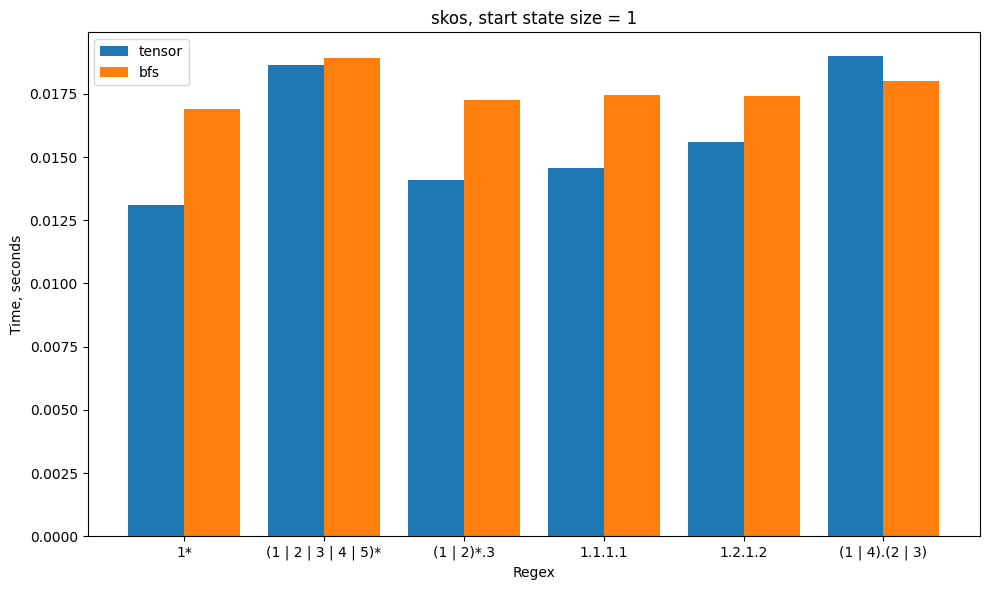

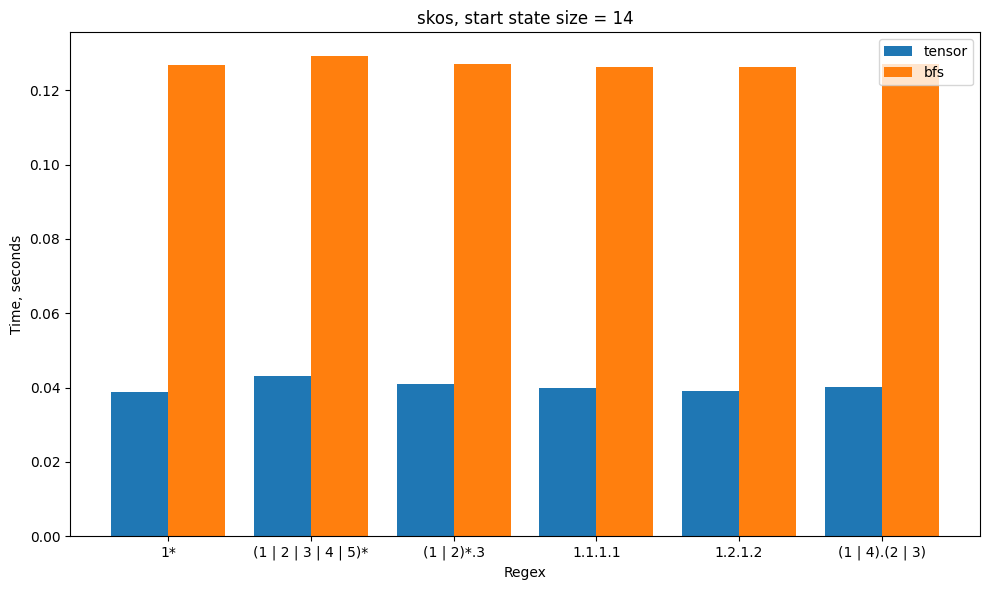

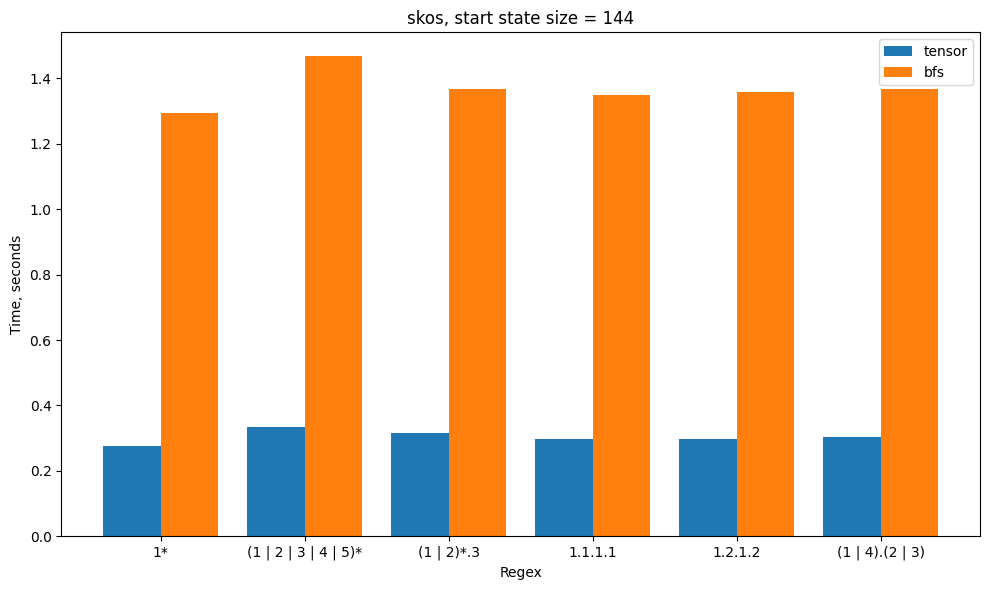

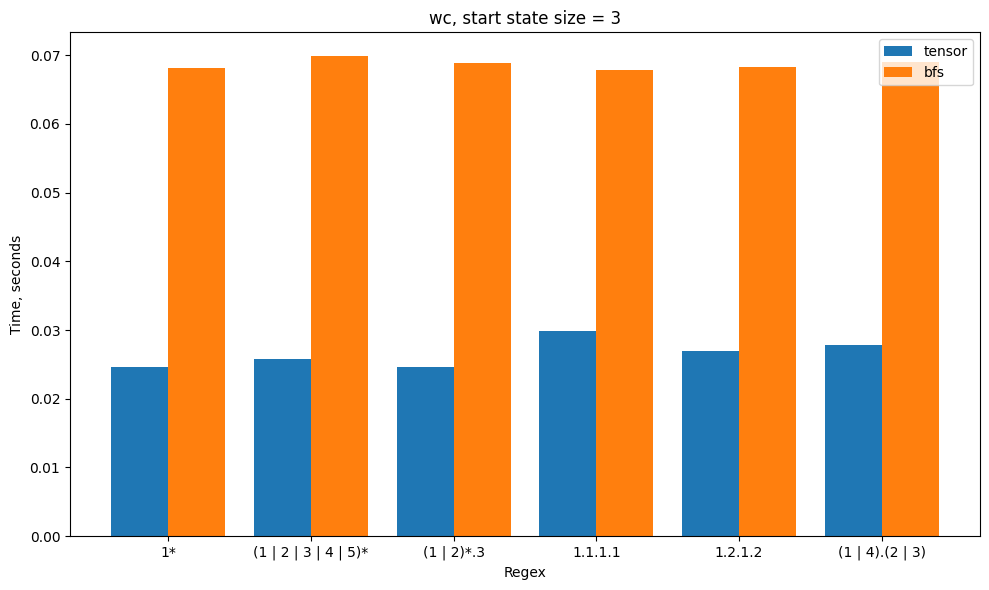

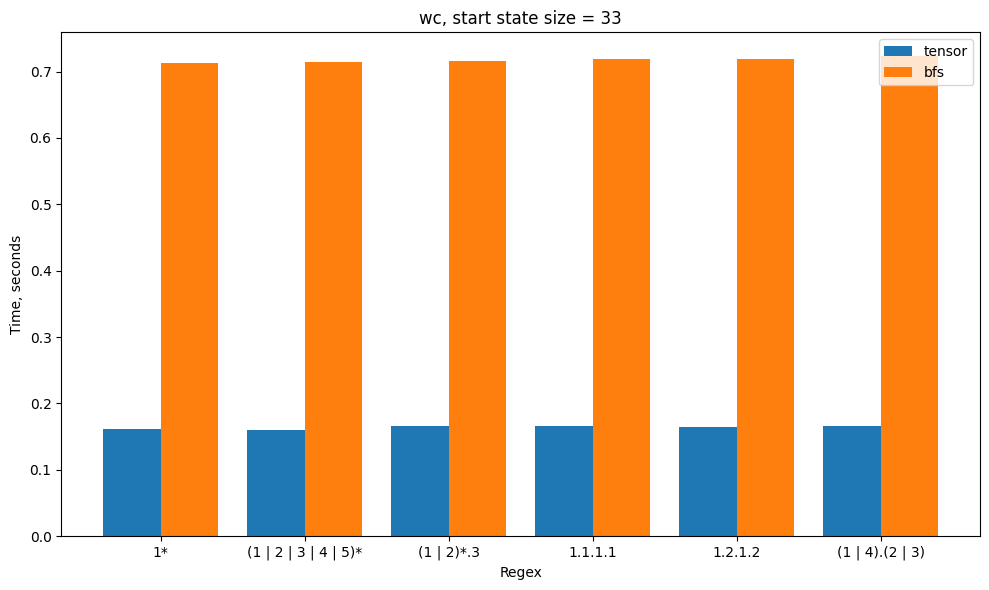

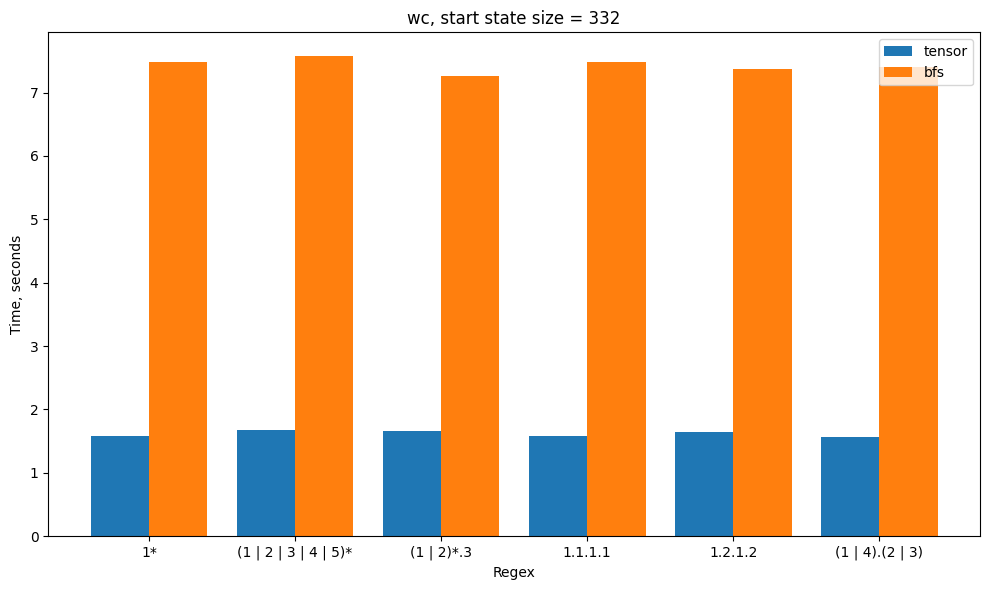

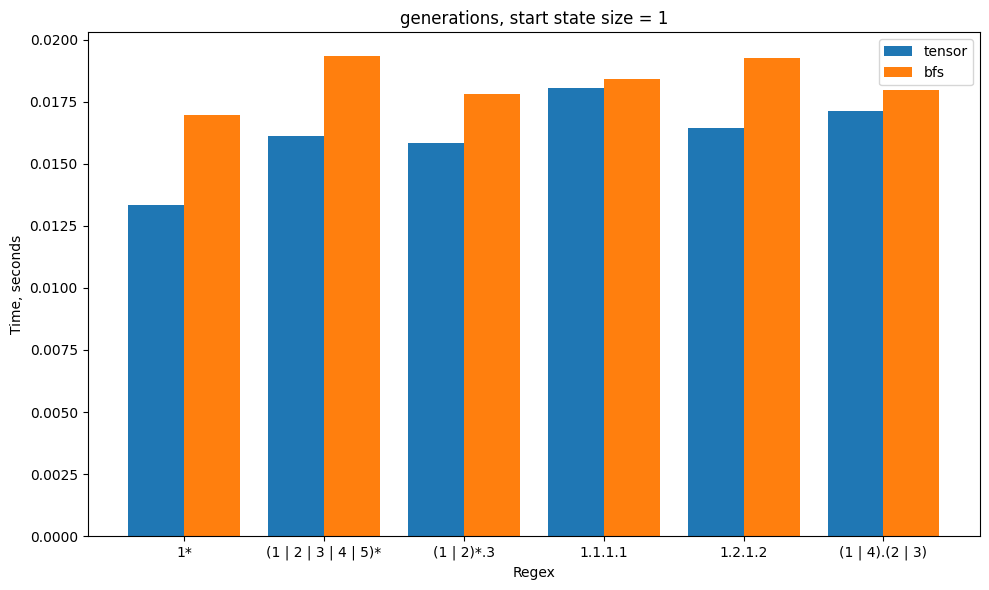

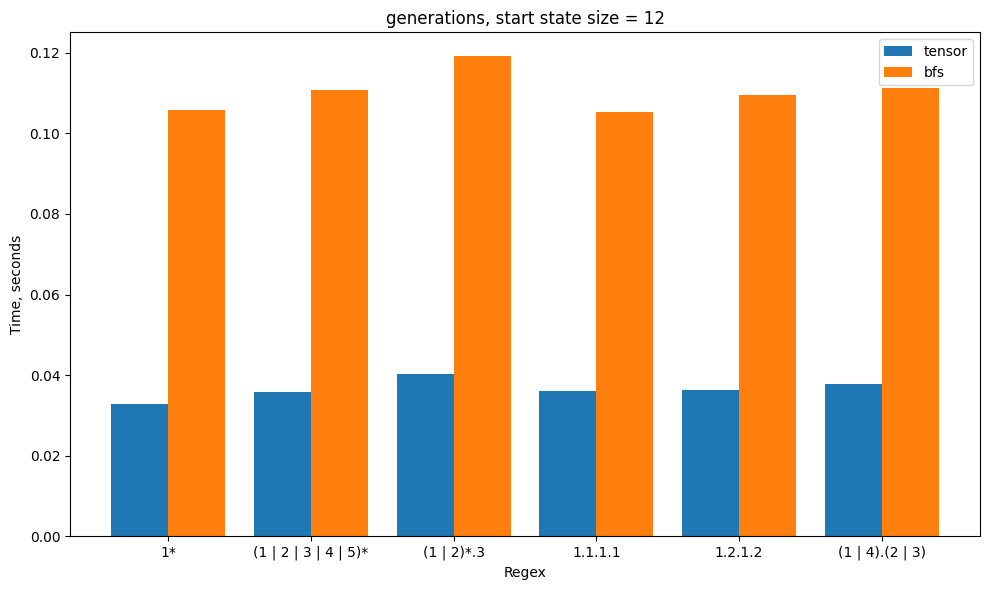

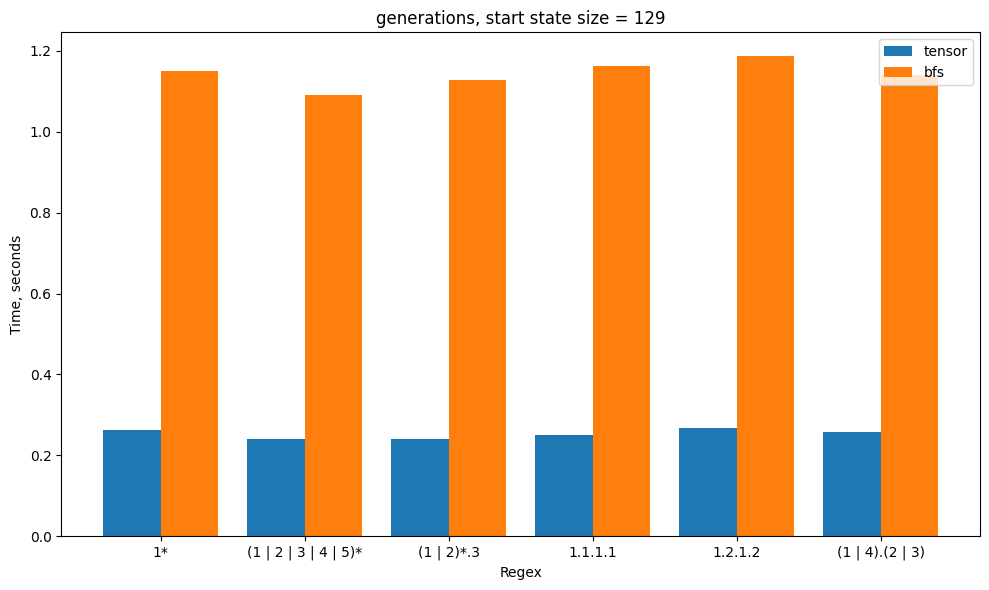

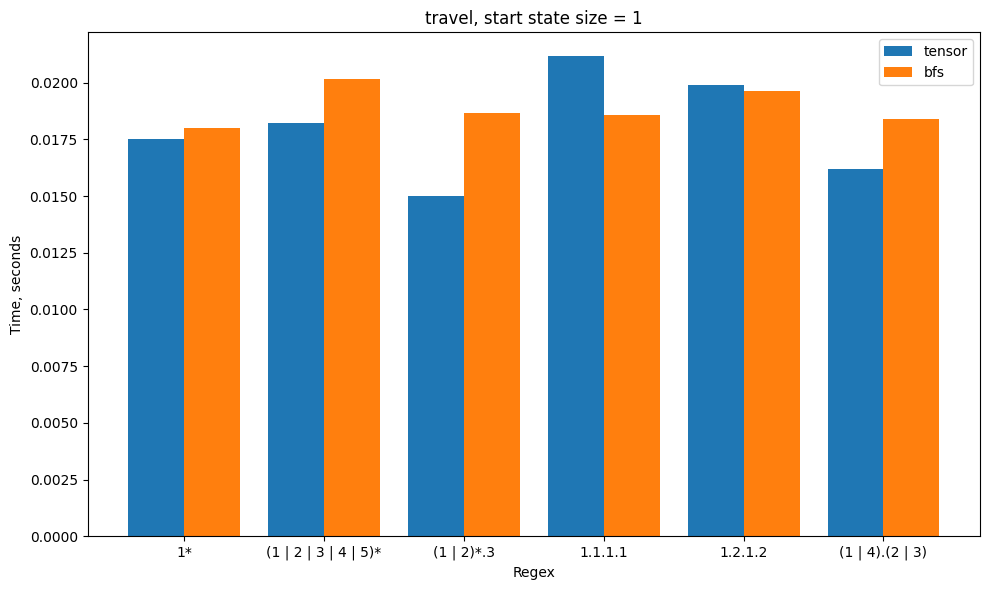

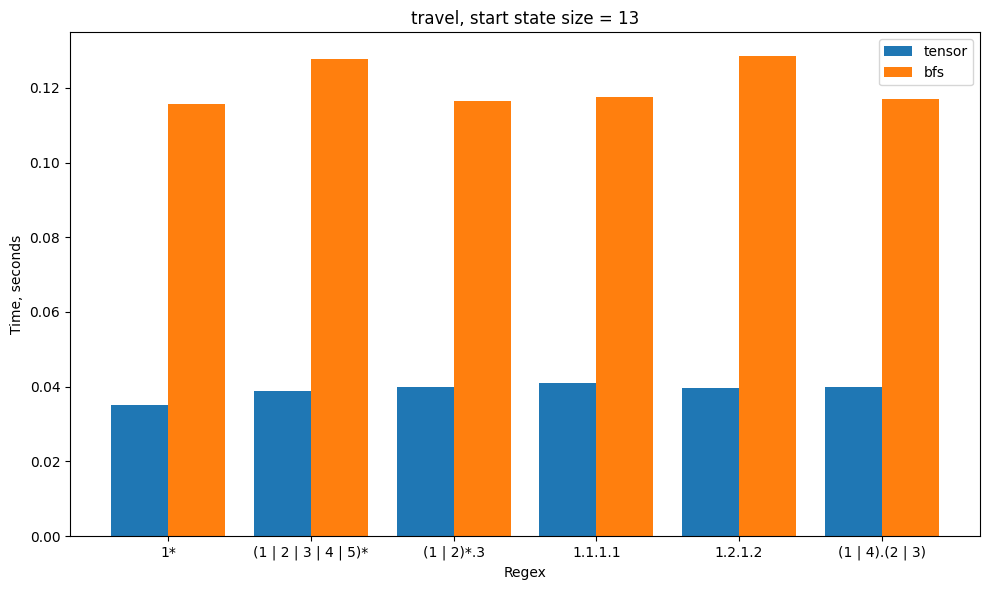

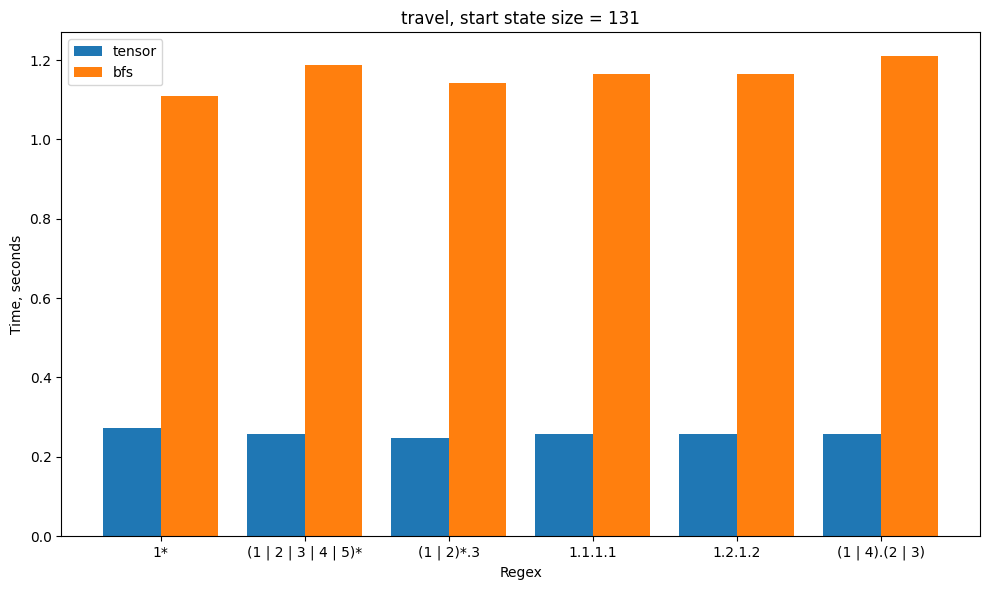

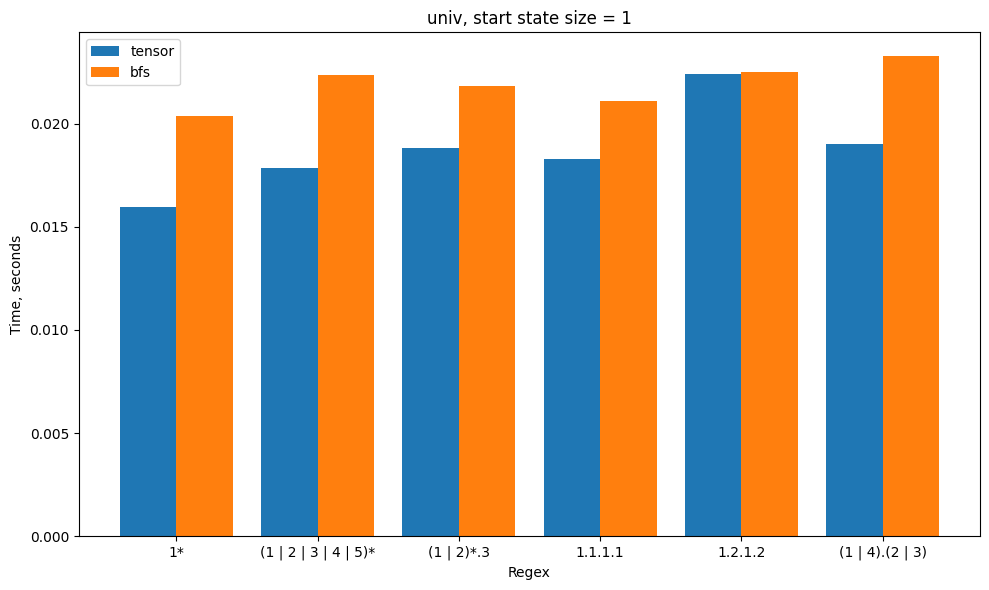

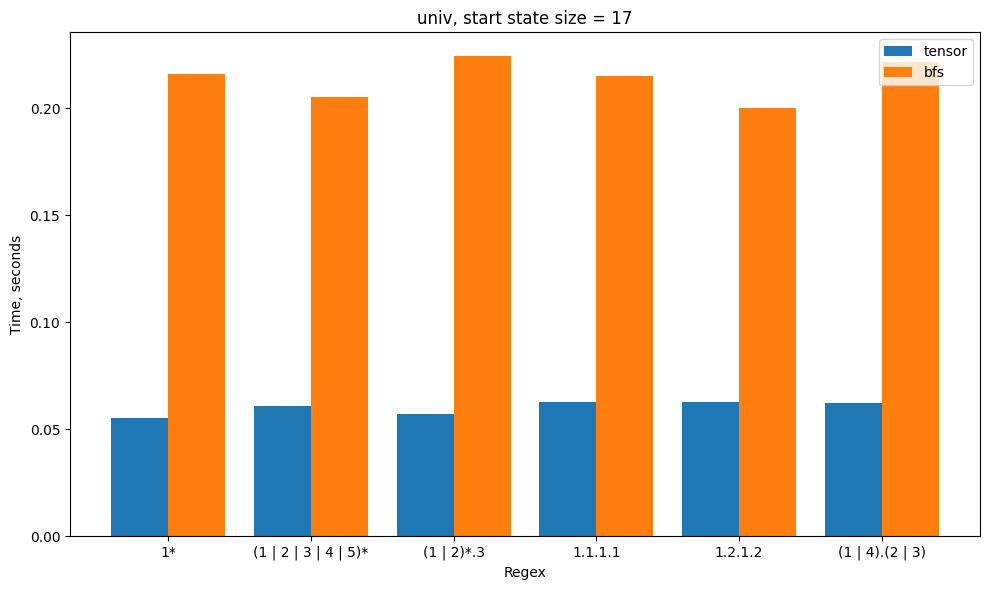

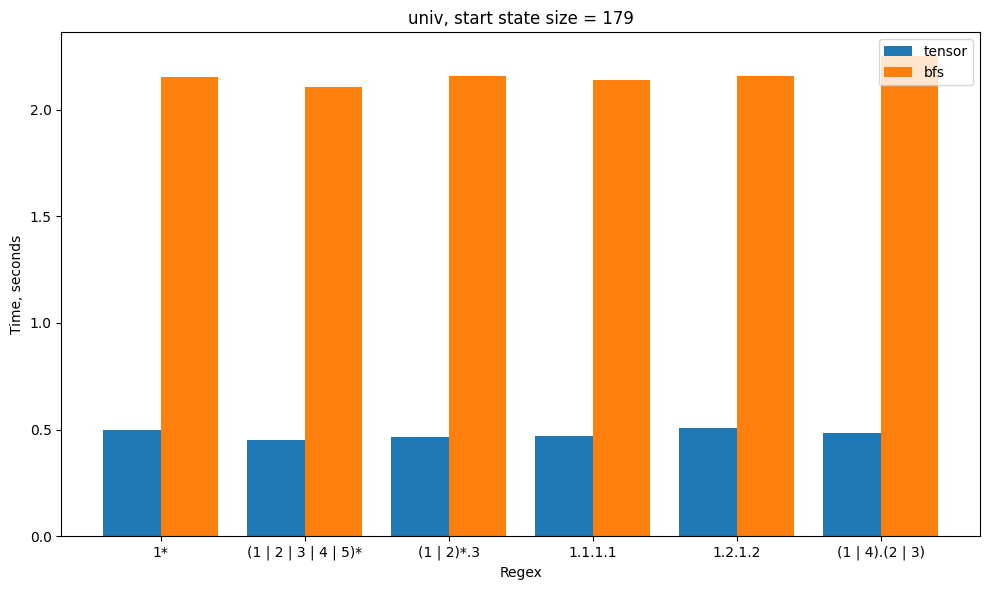

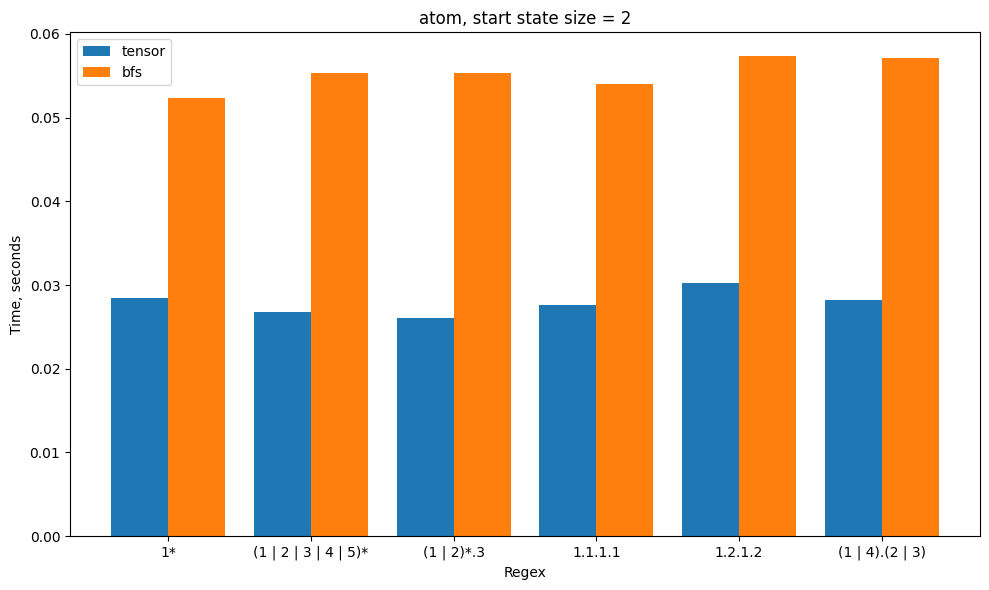

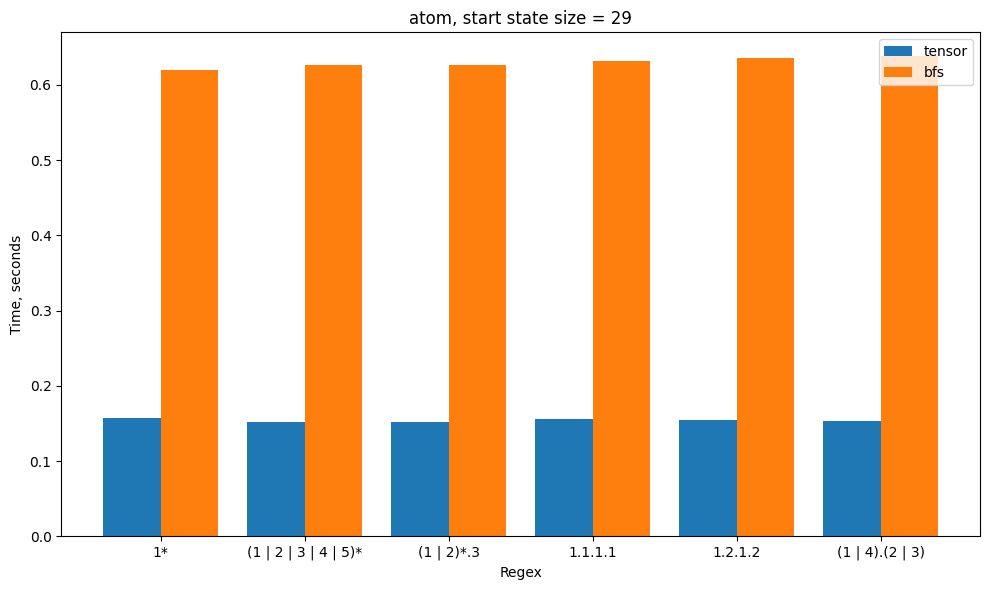

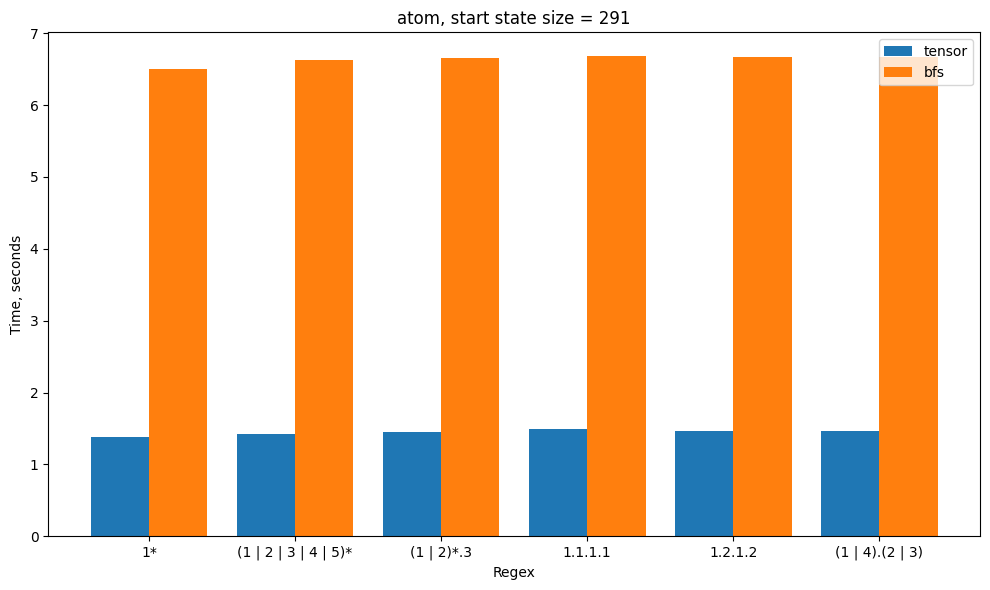

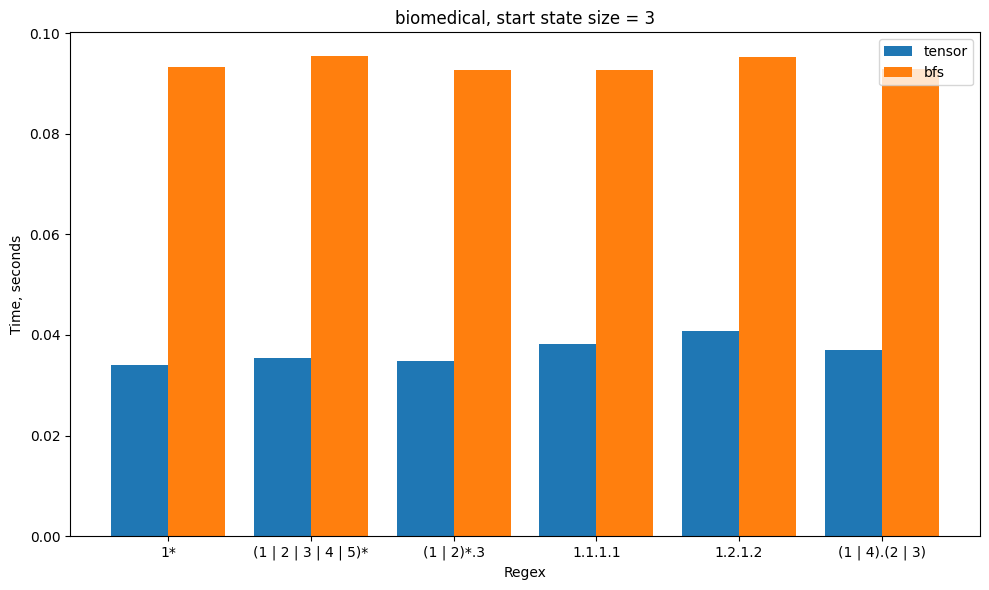

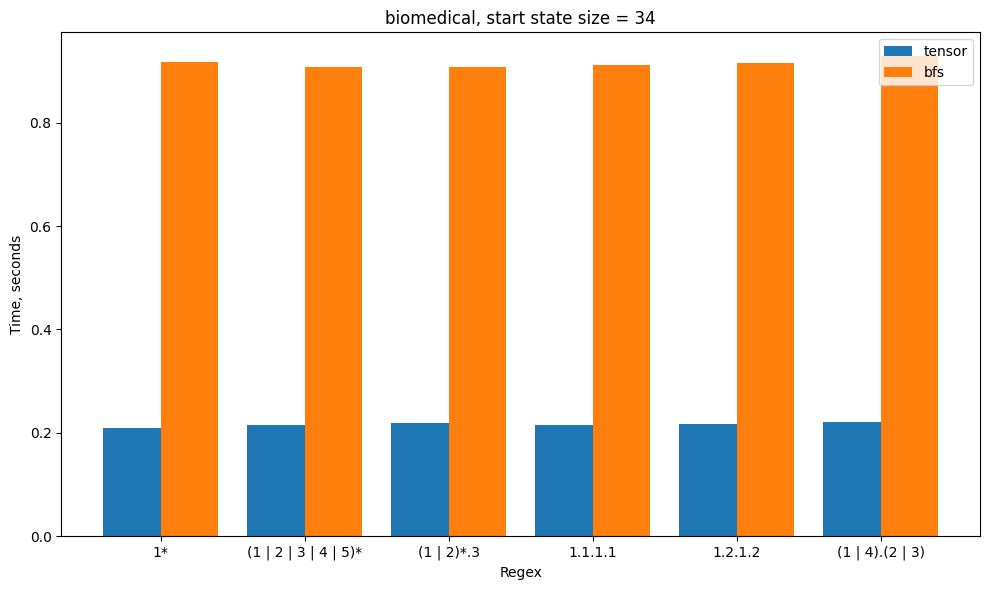

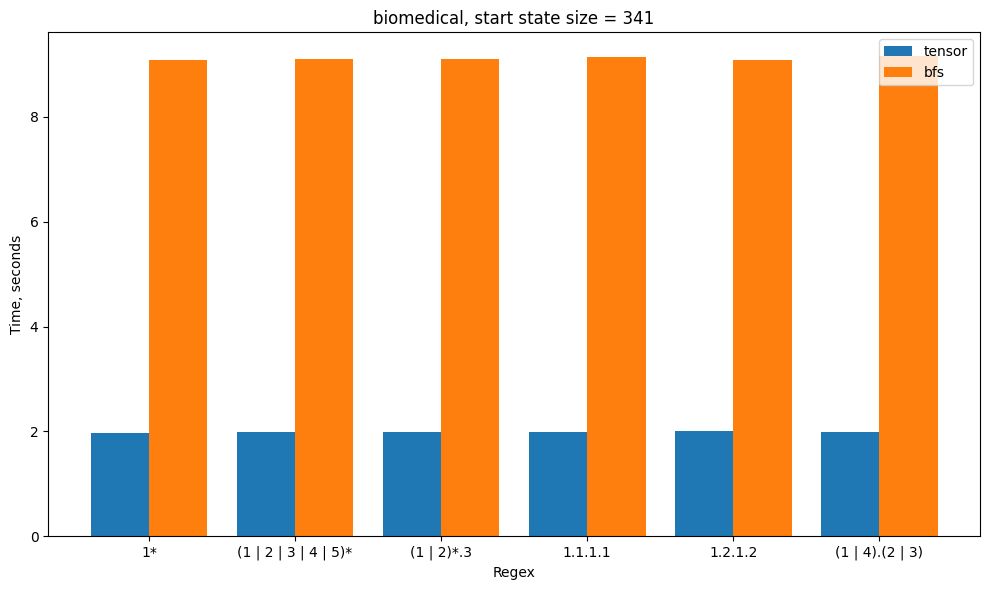

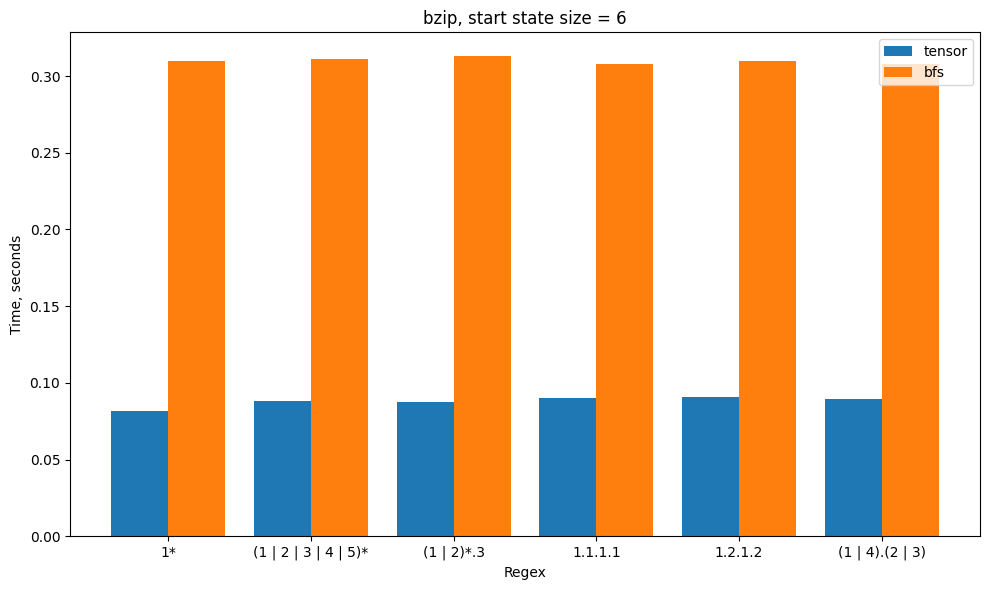

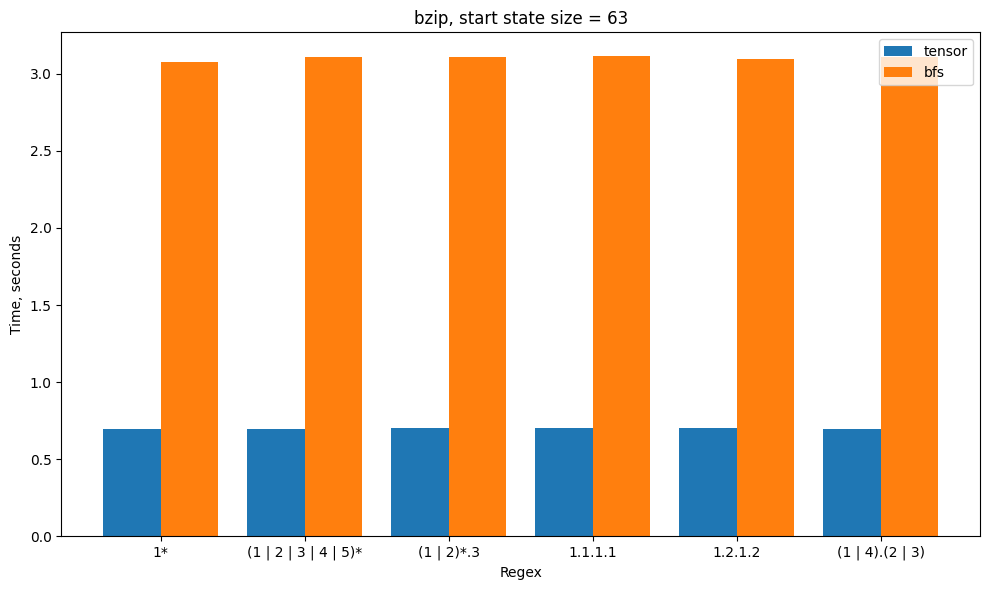

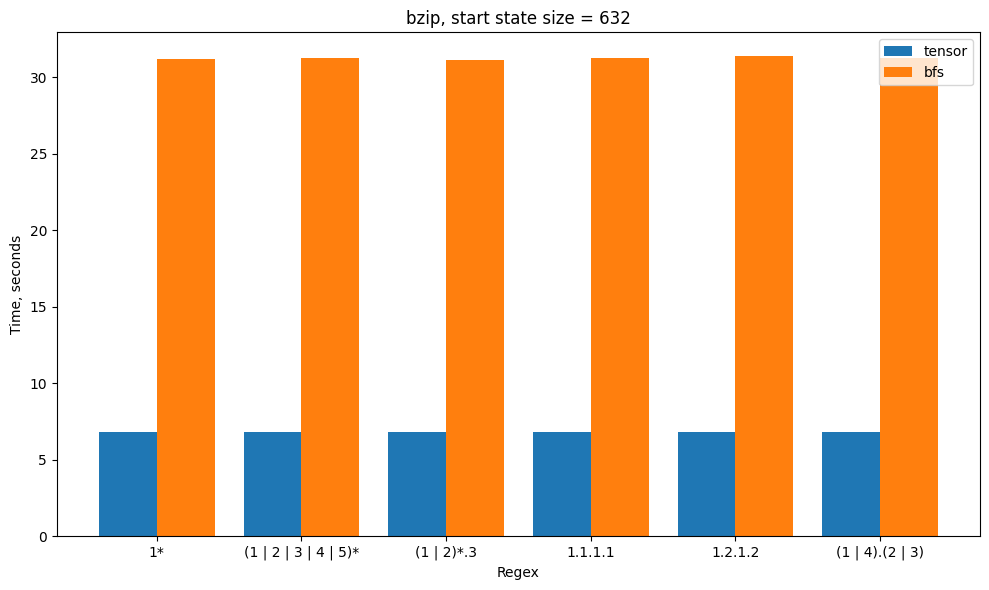

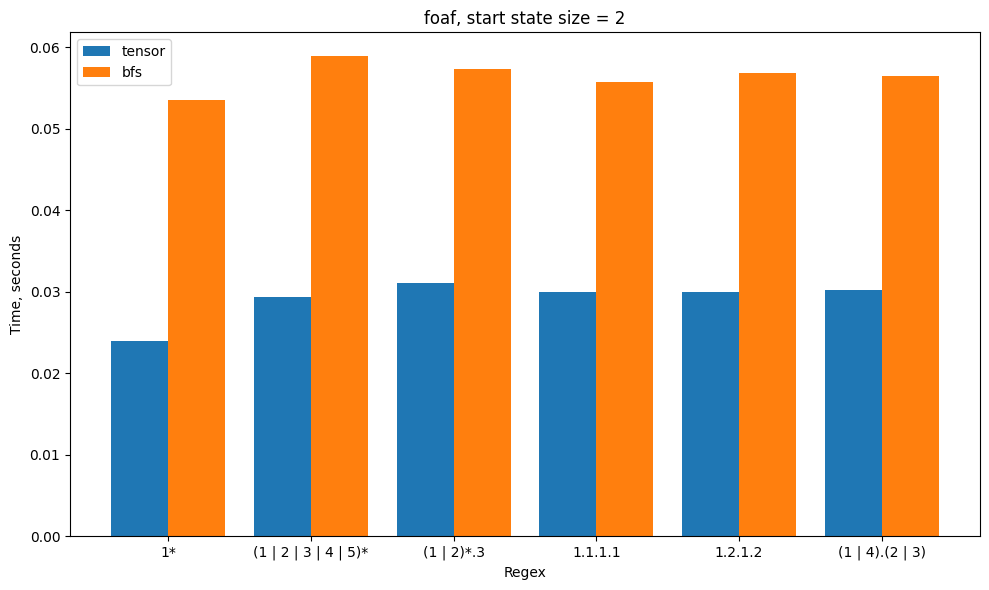

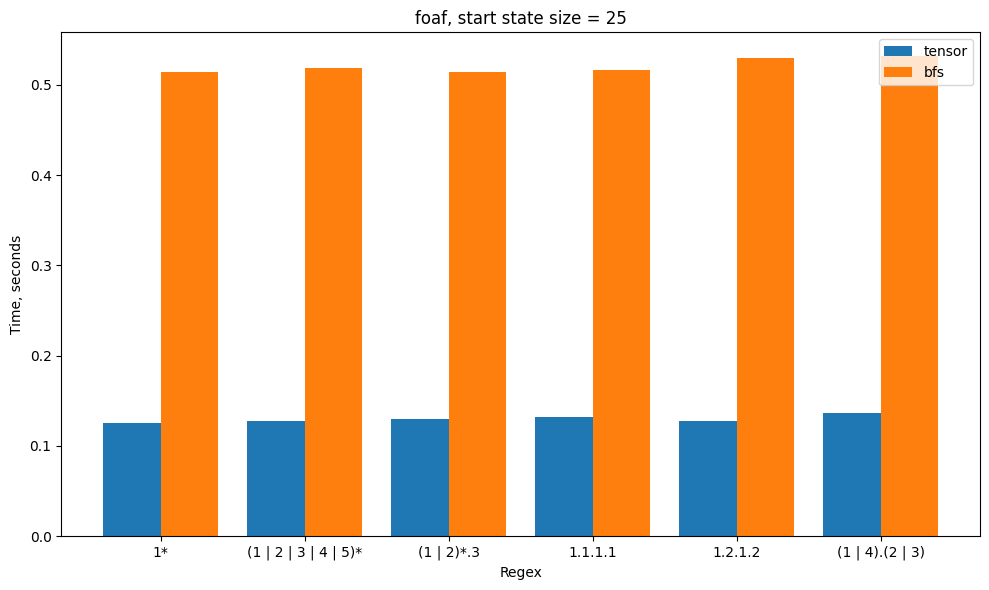

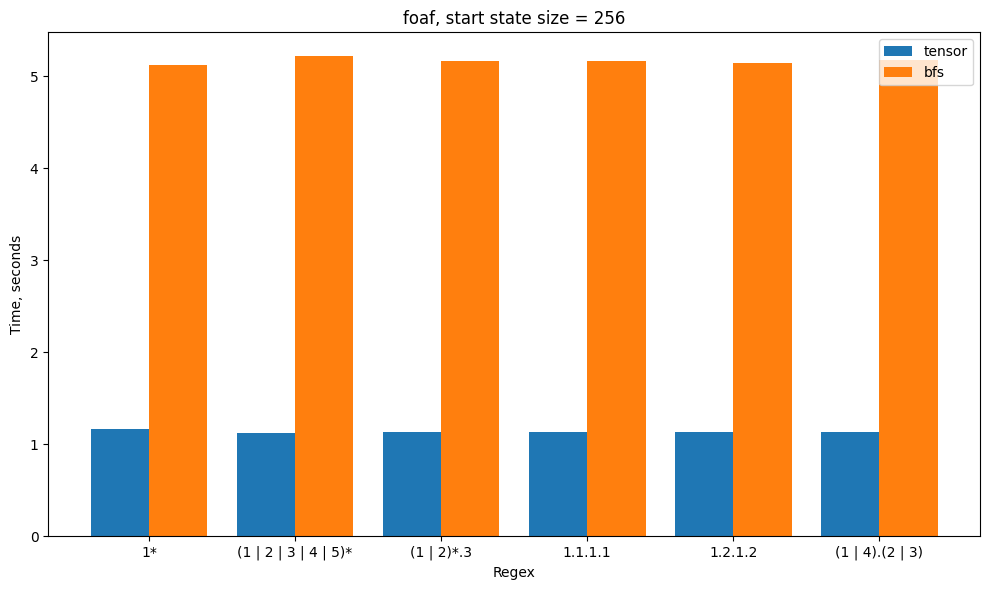

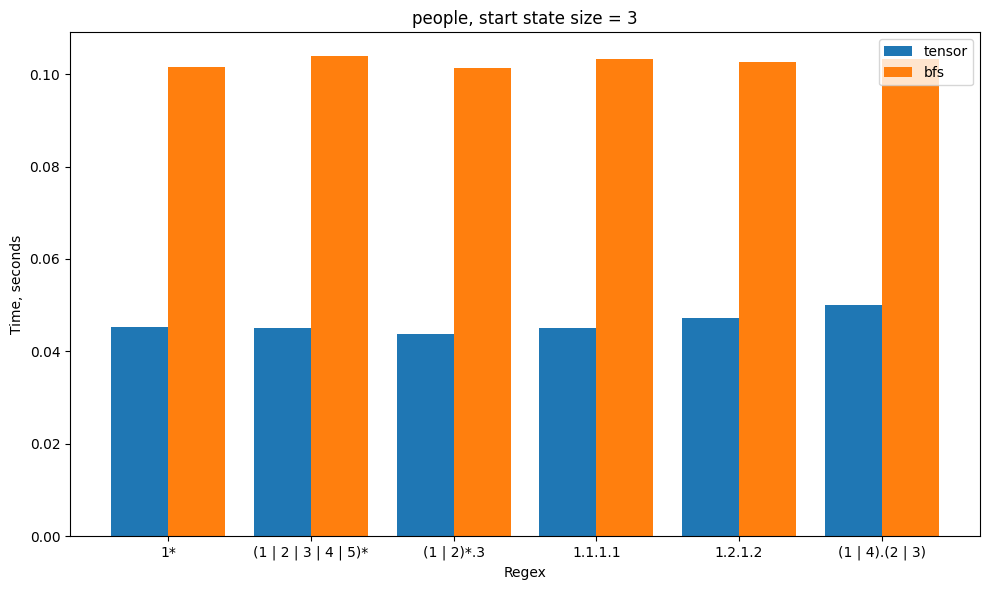

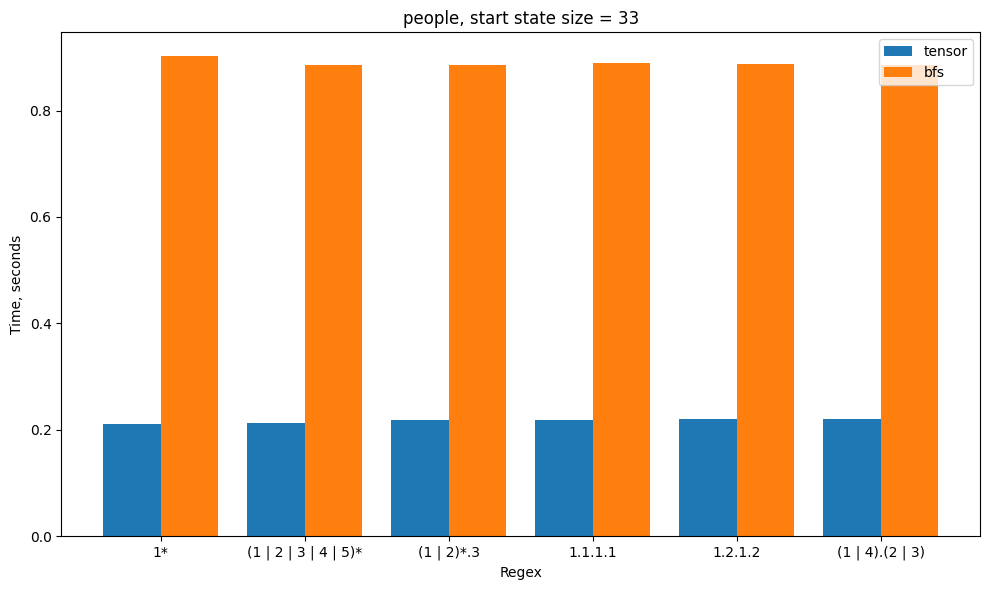

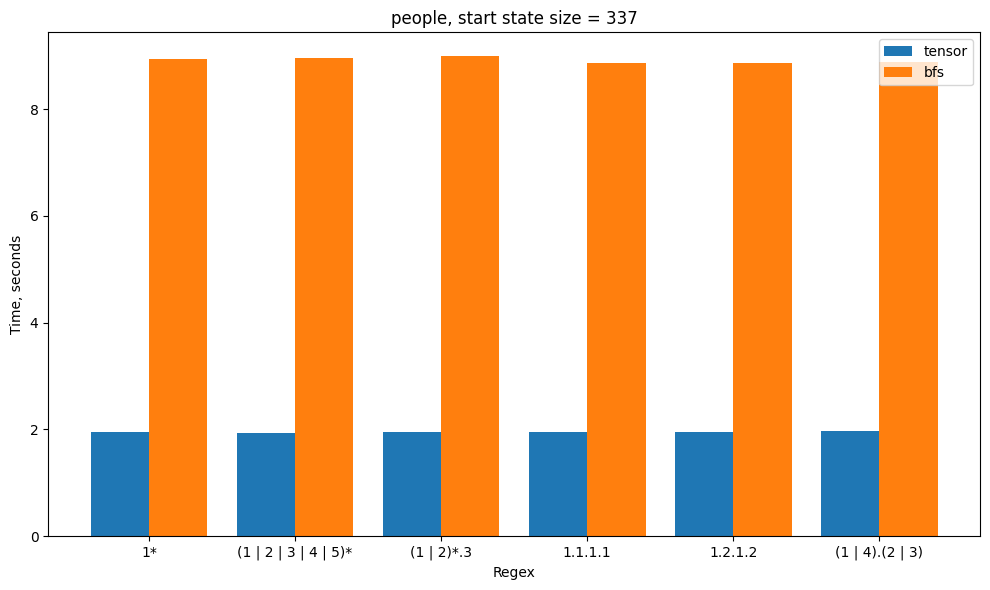

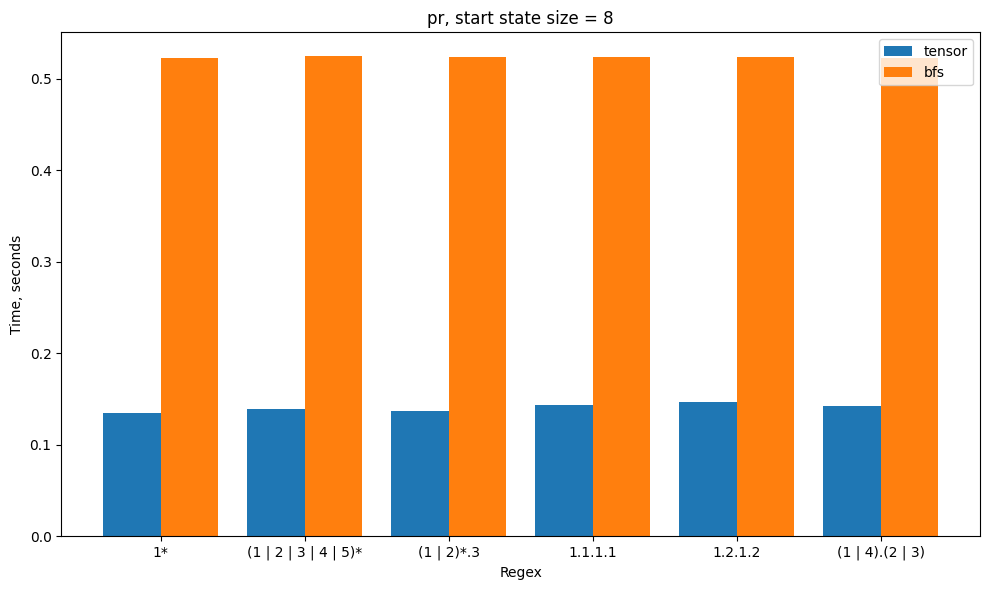

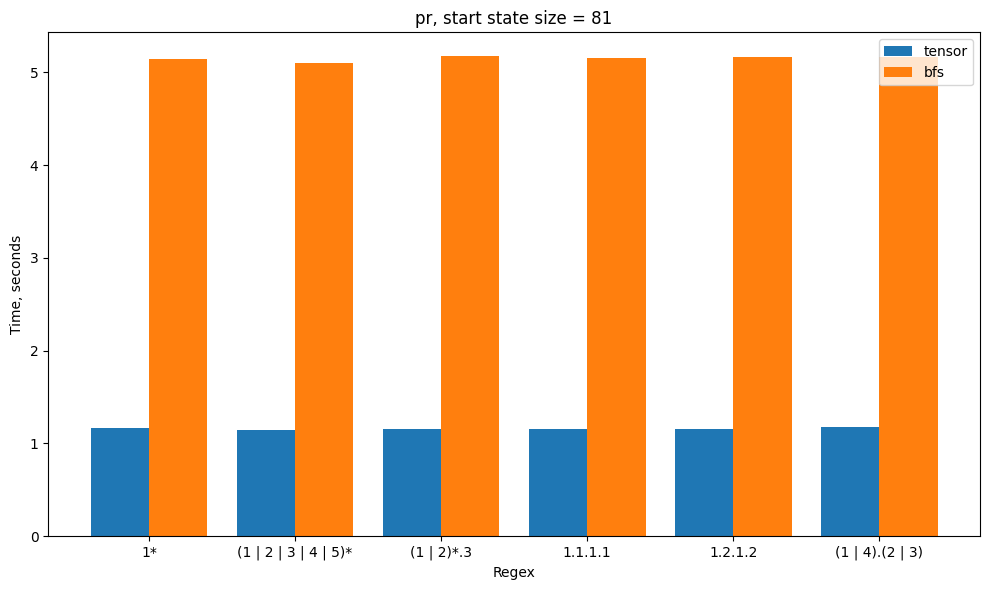

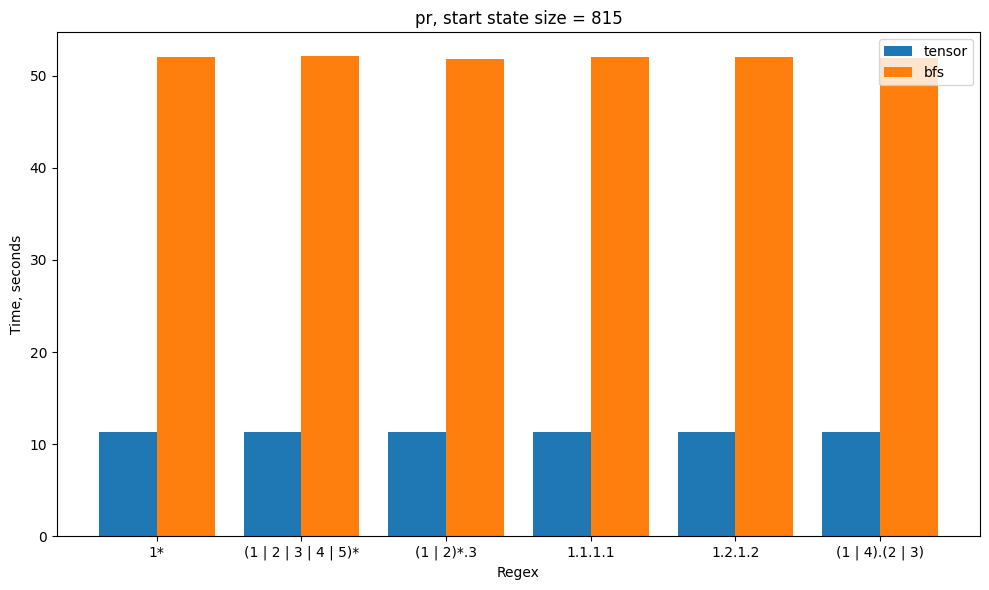

In [51]:
import matplotlib.pyplot as plt

def create_grouped_bar_plot(data_dict, title, group_names, xlabel='Regex', ylabel='Time, seconds', figsize=(10, 6)):
    """
    Create a grouped bar plot from a dictionary.

    Args:
    - data_dict (dict): A dictionary where keys are categories and values are lists of values.
    - title (str): The title of the plot. 
    - group_names (list): The names of groups.
    - xlabel (str, optional): The label for the x-axis. 
    - ylabel (str, optional): The label for the y-axis. 
    - figsize (tuple, optional): The figure size. Defaults to (10, 6).
    """
    # Check if the input is a dictionary
    if not isinstance(data_dict, dict):
        raise ValueError("Input must be a dictionary")

    # Get the categories and values
    categories = list(data_dict.keys())
    values = list(data_dict.values())

    # Check if all values are lists
    if not all(isinstance(value, list) for value in values):
        raise ValueError("All values must be lists")

    # Get the number of groups
    num_groups = len(values[0])

    # Create the bar plot
    bar_width = 0.8 / num_groups
    x = numpy.arange(len(categories))

    plt.figure(figsize=figsize)
    for i in range(num_groups):
        plt.bar(x + i * bar_width, [value[i] for value in values], bar_width, label=group_names[i])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(x + (num_groups - 1) * bar_width / 2, categories)
    plt.legend()
    plt.tight_layout()
    plt.show()

def add_to_res_dict(res_dict, graph, regex, data):
    sub_dict = res_dict.get(graph)
    if(sub_dict is None):
        sub_dict = {}
    sub_dict[regex] = data
    res_dict[graph] = sub_dict

def create_plots_by_res_dict(res_dict, group_names):
    for name in res_dict:
        data_dict = res_dict[name]
        create_grouped_bar_plot(data_dict, name, group_names)

res_dict = {}



for tc, (tensor_t, bfs_t) in TEST_ALGO_RES:
    tensor_t = remove_outlier(tensor_t)
    bfs_t = remove_outlier(bfs_t)

    name = f"{tc.graph_name}, start state size = {len(tc.start_states)}"
    regex = tc.regex

    tensor_res = numpy.mean(tensor_t)
    bfs_res = numpy.mean(bfs_t)
    add_to_res_dict(res_dict, name, regex, [tensor_res, bfs_res])

create_plots_by_res_dict(res_dict, ["tensor", "bfs"])

### Представление матриц

#### Описание данных

Для изучения подходящих прелставооений матриц для задачи `tensor_based_rpq`, были выбраны наборы тестов из `TEST_CASES_ALGO` включающие в себя графы:
- `people`
- `pr`

In [33]:
TEST_CASES_MATRIX_TENSOR = []
good_graphs = set(["people", "pr"])


for tc in TEST_CASES_ALGO:
    if tc.graph_name in good_graphs:
        TEST_CASES_MATRIX_TENSOR.append(tc)

Для изучения подходящих прелставооений матриц для задачи `ms_bfs_based_rpq`, были выбраны наборы тестов из `TEST_CASES_ALGO` включающие в себя графы:
- `people`
- `foaf`

In [34]:
TEST_CASES_MATRIX_BFS = []
good_graphs = set(["people", "foaf"])

for tc in TEST_CASES_ALGO:
    if tc.graph_name in good_graphs:
        TEST_CASES_MATRIX_BFS.append(tc)

#### Результаты
##### `tensor_based_rpq`

In [35]:
from experiments.help.module_patcher import replace_matrix
from pathlib import Path
from typing import Dict, Callable

MATRIX_TYPES = ["csc", "csr", "coo", "dok"]


def create_new_tensor_function() -> Dict[str, Callable]:
    res_dict = {}
    for new in MATRIX_TYPES:
        mod = replace_matrix(Path("../project/graph_util.py"), {"csc": new})
        res_dict[new] = mod.tensor_based_rpq
    return res_dict


def run_test_case_matrix(
    tc: TestCase, funcs: Dict[str, Callable]
) -> Dict[str, List[float]]:
    res_dict = {}
    for matrix_type in funcs.keys():
        rpq_func = funcs[matrix_type]
        time_lst = []
        for _ in range(LAUNCH_COUNT):
            t = _run_rpq_func(rpq_func, tc.regex, tc.graph, tc.start_states)
            time_lst.append(t)
        res_dict[matrix_type] = time_lst

    return res_dict


TENSOR_FCNS = create_new_tensor_function()

TEST_MATRIX_TENSOR_RES = []

for tc in TEST_CASES_MATRIX_TENSOR:
    TEST_MATRIX_TENSOR_RES.append((tc, run_test_case_matrix(tc, TENSOR_FCNS)))

In [36]:
c_graph = []
c_regex = []
c_start_set_size = []

c_time_dict: Dict = {}

for tc, (dict_tensor_t) in TEST_MATRIX_TENSOR_RES:
    c_graph.append(tc.graph_name)
    c_regex.append(tc.regex)
    c_start_set_size.append(len(tc.start_states))

    for matrix_type in dict_tensor_t.keys():
        lst = c_time_dict.get(matrix_type)
        if lst is None:
            c_time_dict[matrix_type] = []
            lst = c_time_dict[matrix_type]

        all_time_lst = dict_tensor_t[matrix_type]
        all_time_lst = remove_outlier(all_time_lst)

        lst.append(format_res(all_time_lst))

pandas.set_option("display.max_rows", None)

pd_dict = {"graph": c_graph, "regex": c_regex, "size of start state": c_start_set_size}

pd_dict.update(c_time_dict)

pandas.DataFrame(pd_dict)

,graph,regex,size of start state,csc,csr,coo,dok
0,people,1*,3,0.0317 ± 0.0005,0.0309 ± 0.0002,0.0301 ± 0.0004,0.0358 ± 0.0002
1,people,(1 | 2 | 3 | 4 | 5)*,3,0.03248 ± 0.00010,0.0328 ± 0.0003,0.0325 ± 0.0006,0.03831 ± 0.00009
2,people,(1 | 2)*.3,3,0.03302 ± 0.00009,0.03314 ± 0.00006,0.0323 ± 0.0002,0.0375 ± 0.0002
3,people,1.1.1.1,3,0.0344 ± 0.0001,0.03469 ± 0.00009,0.0337 ± 0.0001,0.0407 ± 0.0002
4,people,1.2.1.2,3,0.0343 ± 0.0001,0.03445 ± 0.00008,0.0336 ± 0.0001,0.0405 ± 0.0001
5,people,(1 | 4).(2 | 3),3,0.0335 ± 0.0001,0.03372 ± 0.00009,0.03276 ± 0.00009,0.03886 ± 0.00010
6,people,1*,33,0.1512 ± 0.0003,0.1528 ± 0.0006,0.1518 ± 0.0003,0.1570 ± 0.0005
7,people,(1 | 2 | 3 | 4 | 5)*,33,0.1514 ± 0.0004,0.1534 ± 0.0004,0.1527 ± 0.0005,0.1584 ± 0.0004
8,people,(1 | 2)*.3,33,0.1508 ± 0.0003,0.1527 ± 0.0004,0.1517 ± 0.0003,0.1579 ± 0.0010
9,people,1.1.1.1,33,0.1522 ± 0.0002,0.1541 ± 0.0003,0.1536 ± 0.0003,0.1614 ± 0.0003


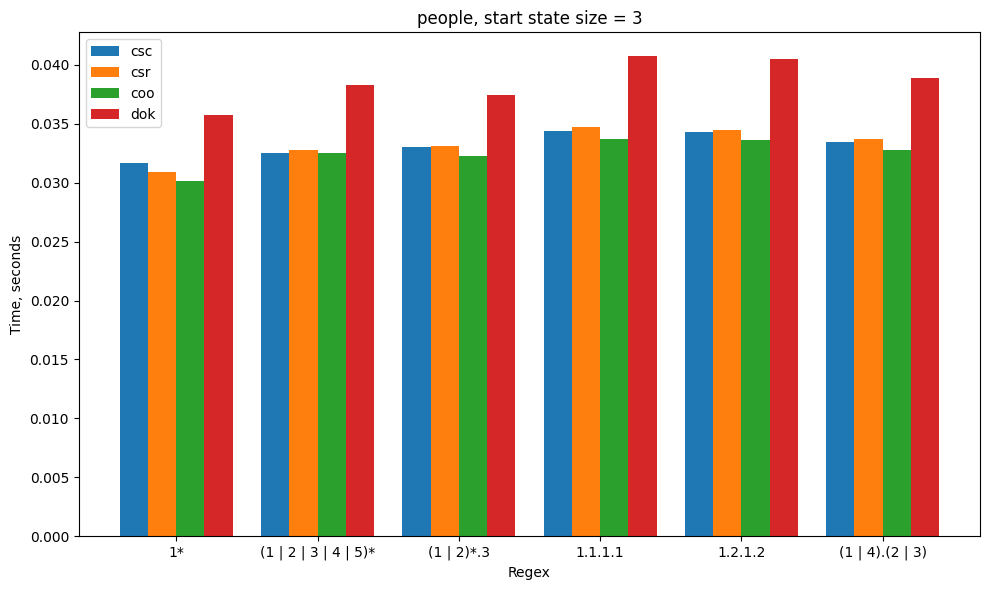

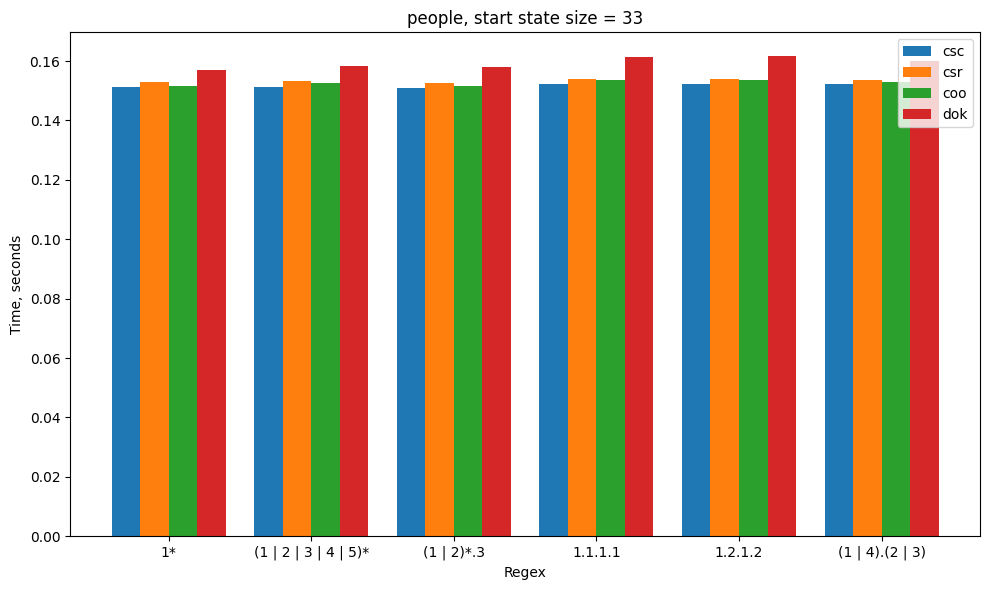

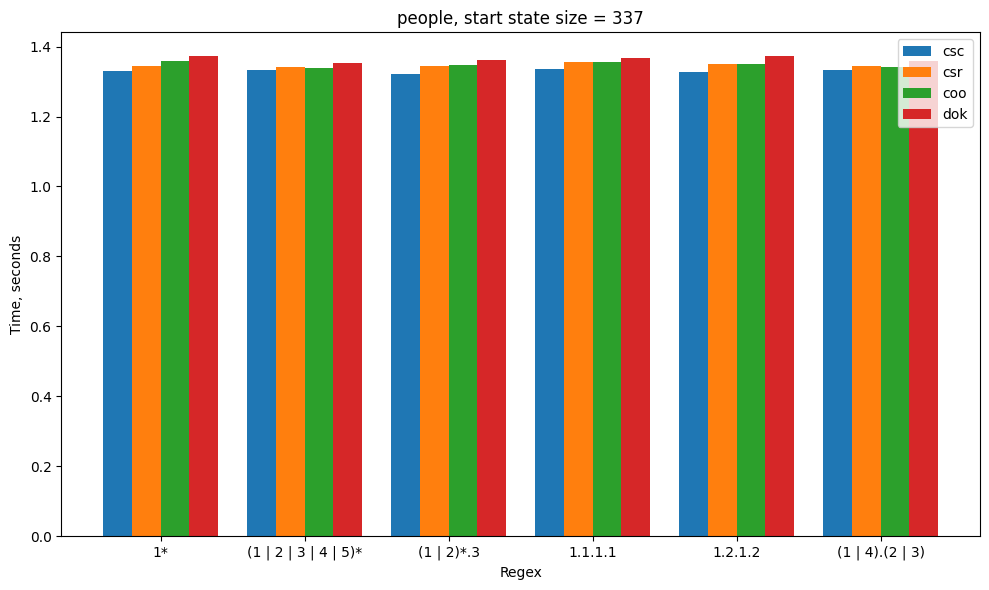

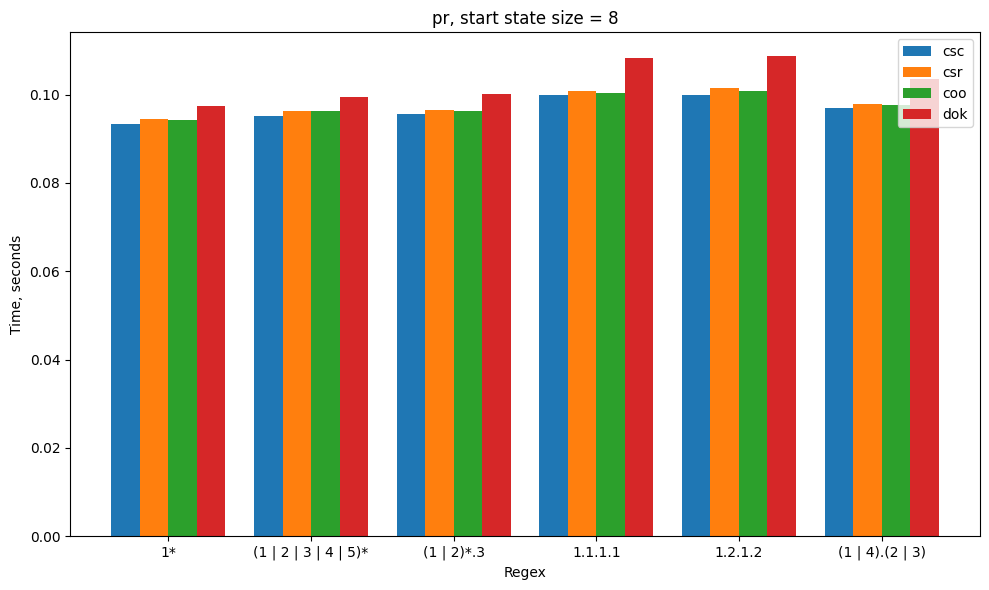

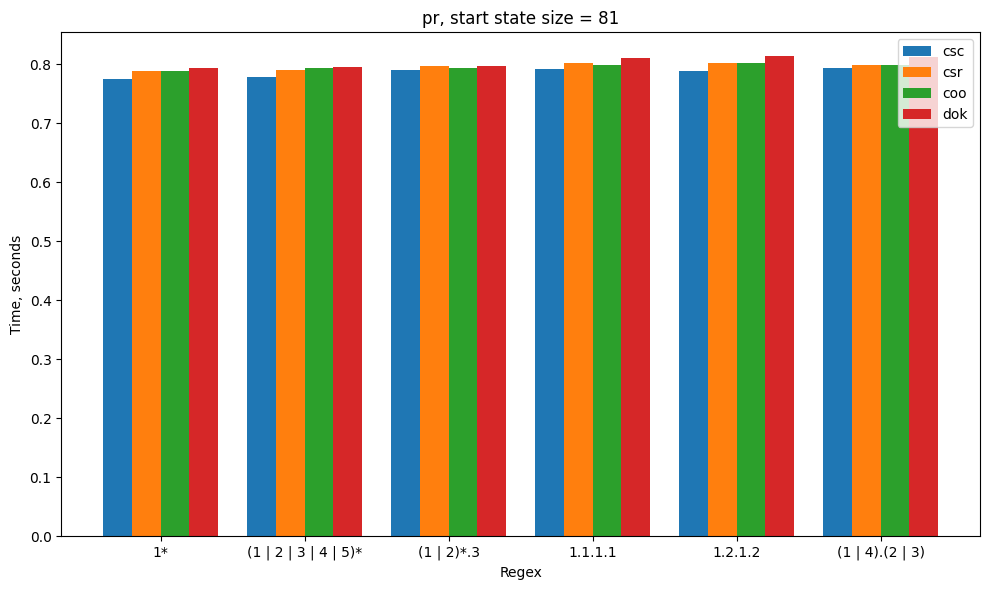

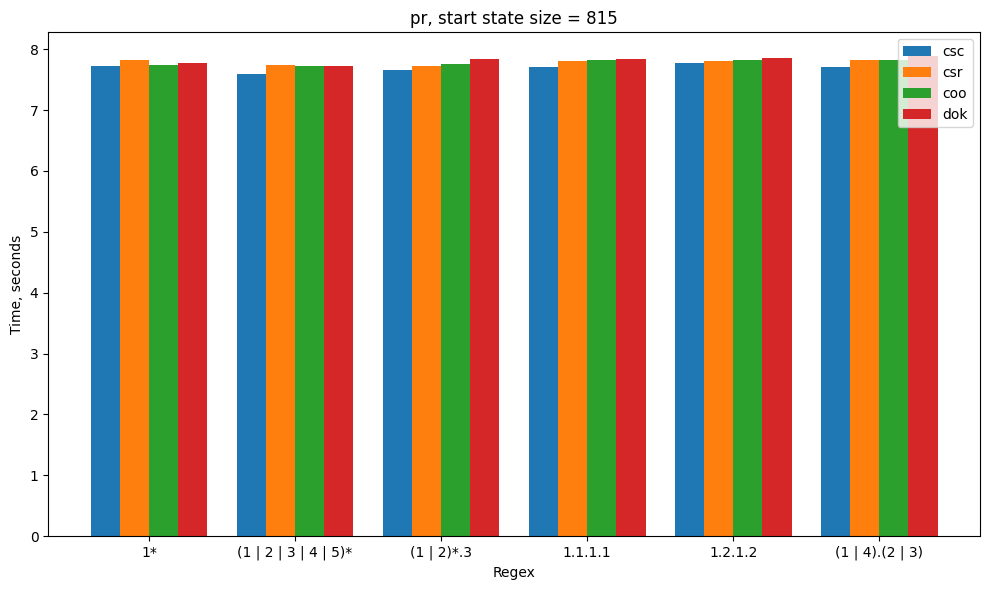

In [56]:
res_dict = {}

c_names = []
c_regex = []

c_time_dict: Dict = {}

for tc, (dict_tensor_t) in TEST_MATRIX_TENSOR_RES:
    c_names.append(f"{tc.graph_name}, start state size = {len(tc.start_states)}")
    c_regex.append(tc.regex)
    

    for matrix_type in dict_tensor_t.keys():
        lst = c_time_dict.get(matrix_type)
        if lst is None:
            c_time_dict[matrix_type] = []
            lst = c_time_dict[matrix_type]

        all_time_lst = dict_tensor_t[matrix_type]
        all_time_lst = remove_outlier(all_time_lst)
        lst.append(numpy.mean(all_time_lst))

group_names = list(c_time_dict.keys())

for i in range(len(c_names)):
    add_to_res_dict(res_dict, c_names[i], c_regex[i], [c_time_dict[k][i] for k in group_names])
    
create_plots_by_res_dict(res_dict, group_names)

##### `ms_bfs_based_rpq`

In [37]:
buf = set(MATRIX_TYPES)
buf.discard("coo")
buf.discard("dok")
MATRIX_TYPES_NO_COO_DOK = list(buf)


def create_new_bfs_funcs() -> Dict[str, Callable]:
    res_dict = {}
    for new1 in MATRIX_TYPES:
        for new2 in MATRIX_TYPES_NO_COO_DOK:
            mod = replace_matrix(
                Path("../project/bfs_rpq.py"), {"csc": new1, "csr": new2}
            )
            res_dict[f"{new1} | {new2}"] = mod.ms_bfs_based_rpq
    return res_dict


BFS_FNCS = create_new_bfs_funcs()

TEST_MATRIX_BFS_RES = []

for tc in TEST_CASES_MATRIX_BFS:
    TEST_MATRIX_BFS_RES.append((tc, run_test_case_matrix(tc, BFS_FNCS)))

In [38]:
c_graph = []
c_regex = []
c_start_set_size = []
c_time_dict: Dict = {}

for tc, (dict_bfs_t) in TEST_MATRIX_BFS_RES:
    c_graph.append(tc.graph_name)
    c_regex.append(tc.regex)
    c_start_set_size.append(len(tc.start_states))

    for matrix_type in dict_bfs_t.keys():
        lst = c_time_dict.get(matrix_type)
        if lst is None:
            c_time_dict[matrix_type] = []
            lst = c_time_dict[matrix_type]

        all_time_lst = dict_bfs_t[matrix_type]
        all_time_lst = remove_outlier(all_time_lst)

        lst.append(format_res(all_time_lst))


pandas.set_option("display.max_rows", None)
pd_dict = {"graph": c_graph, "regex": c_regex, "size of start state": c_start_set_size}
pd_dict.update(c_time_dict)
pandas.DataFrame(pd_dict)

,graph,regex,size of start state,csc | csc,csc | csr,csr | csc,csr | csr,coo | csc,coo | csr,dok | csc,dok | csr
0,foaf,1*,2,0.0418 ± 0.0004,0.0404 ± 0.0001,0.0417 ± 0.0002,0.0399 ± 0.0001,0.0401 ± 0.0002,0.0394 ± 0.0001,0.04227 ± 0.00007,0.04166 ± 0.00009
1,foaf,(1 | 2 | 3 | 4 | 5)*,2,0.0425 ± 0.0002,0.0418 ± 0.0001,0.0426 ± 0.0001,0.04178 ± 0.00007,0.04181 ± 0.00008,0.04103 ± 0.00009,0.04437 ± 0.00005,0.0438 ± 0.0002
2,foaf,(1 | 2)*.3,2,0.0412 ± 0.0002,0.04042 ± 0.00008,0.04142 ± 0.00006,0.04047 ± 0.00010,0.0406 ± 0.0002,0.03965 ± 0.00008,0.0429 ± 0.0001,0.04225 ± 0.00008
3,foaf,1.1.1.1,2,0.04090 ± 0.00005,0.04011 ± 0.00006,0.04106 ± 0.00009,0.04010 ± 0.00005,0.04019 ± 0.00010,0.03951 ± 0.00008,0.04244 ± 0.00007,0.04176 ± 0.00006
4,foaf,1.2.1.2,2,0.04099 ± 0.00008,0.04019 ± 0.00005,0.04111 ± 0.00008,0.04026 ± 0.00007,0.0403 ± 0.0001,0.03945 ± 0.00006,0.0426 ± 0.0001,0.04186 ± 0.00005
5,foaf,(1 | 4).(2 | 3),2,0.0413 ± 0.0001,0.04044 ± 0.00006,0.04139 ± 0.00006,0.04044 ± 0.00008,0.04083 ± 0.00008,0.0401 ± 0.0001,0.0434 ± 0.0001,0.04274 ± 0.00007
6,foaf,1*,25,0.361 ± 0.003,0.350 ± 0.002,0.358 ± 0.002,0.348 ± 0.001,0.356 ± 0.001,0.351 ± 0.001,0.365 ± 0.005,0.355 ± 0.001
7,foaf,(1 | 2 | 3 | 4 | 5)*,25,0.362 ± 0.005,0.3533 ± 0.0007,0.361 ± 0.003,0.3509 ± 0.0008,0.361 ± 0.003,0.353 ± 0.002,0.365 ± 0.002,0.353 ± 0.002
8,foaf,(1 | 2)*.3,25,0.358 ± 0.003,0.3486 ± 0.0008,0.359 ± 0.005,0.349 ± 0.002,0.357 ± 0.002,0.349 ± 0.001,0.362 ± 0.003,0.352 ± 0.001
9,foaf,1.1.1.1,25,0.360 ± 0.001,0.356 ± 0.001,0.361 ± 0.002,0.355 ± 0.002,0.360 ± 0.002,0.356 ± 0.001,0.368 ± 0.003,0.363 ± 0.002


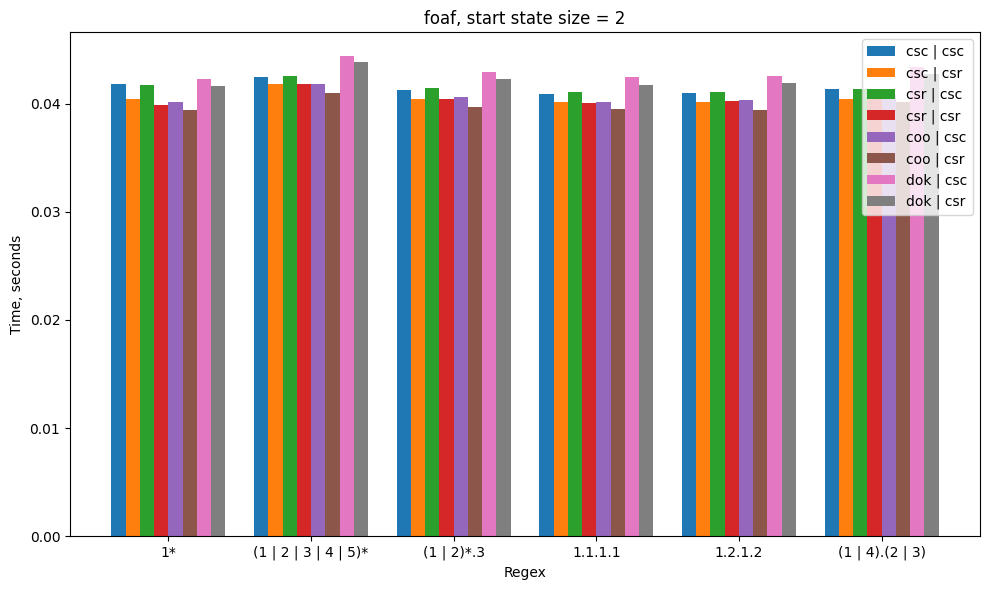

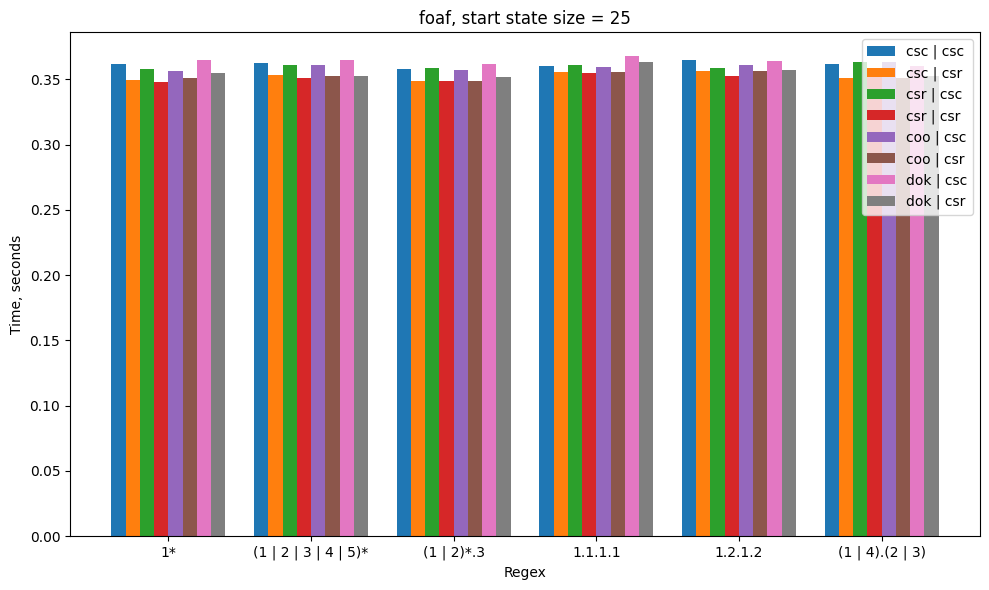

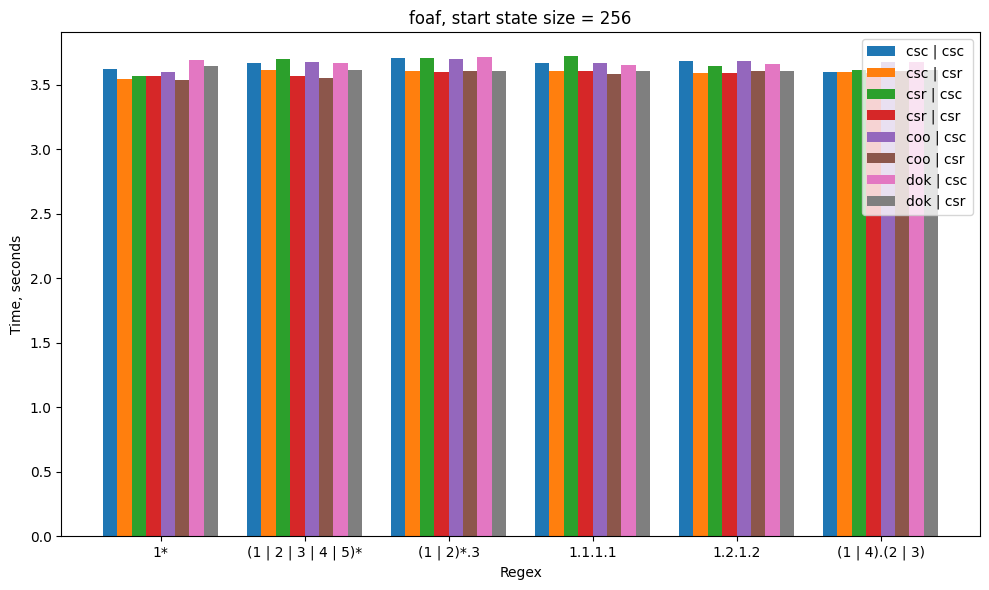

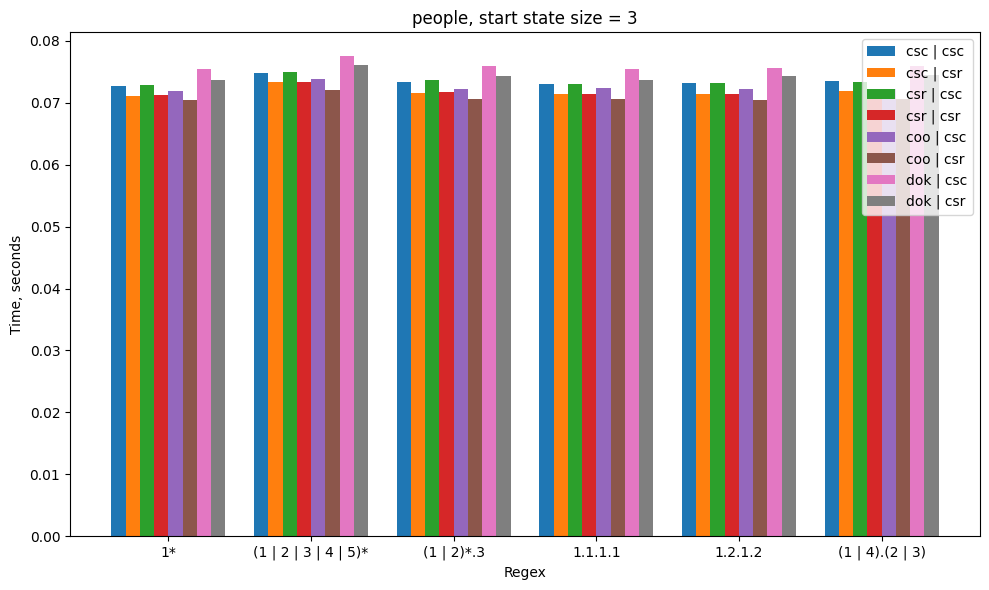

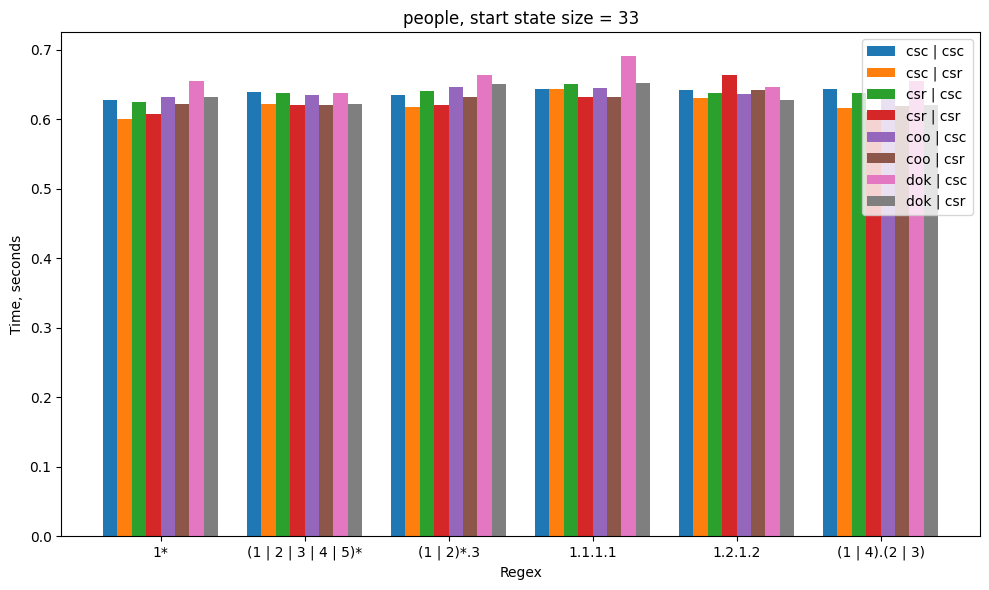

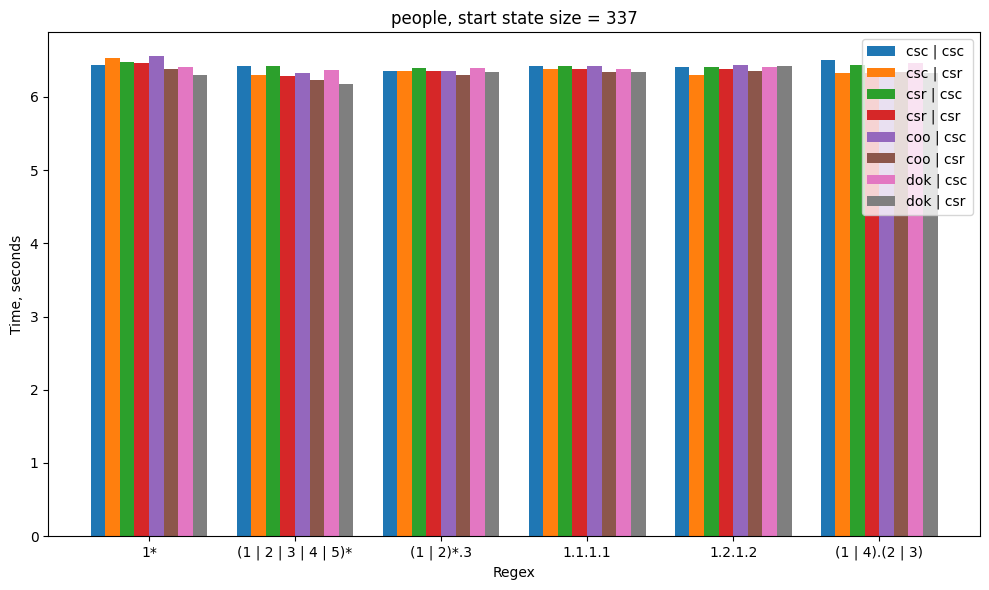

In [57]:
res_dict = {}

c_names = []
c_regex = []

c_time_dict: Dict = {}

for tc, (dict_bfs_t) in TEST_MATRIX_BFS_RES:
    c_names.append(f"{tc.graph_name}, start state size = {len(tc.start_states)}")
    c_regex.append(tc.regex)
    

    for matrix_type in dict_bfs_t.keys():
        lst = c_time_dict.get(matrix_type)
        if lst is None:
            c_time_dict[matrix_type] = []
            lst = c_time_dict[matrix_type]

        all_time_lst = dict_bfs_t[matrix_type]
        all_time_lst = remove_outlier(all_time_lst)
        lst.append(numpy.mean(all_time_lst))

group_names = list(c_time_dict.keys())

for i in range(len(c_names)):
    add_to_res_dict(res_dict, c_names[i], c_regex[i], [c_time_dict[k][i] for k in group_names])
    
create_plots_by_res_dict(res_dict, group_names)

## Анализ результатов экспериментов 

###  Размер стартового множества

Давайте найдём все случаи, когда выгоднее решать задачу для отдельных пар вершин.

In [39]:
c_graph = []
c_regex = []
c_start_set_size = []
c_tensor_time = []
c_bfs_time = []

for tc, (tensor_t, bfs_t) in TEST_ALGO_RES:
    tensor_t = remove_outlier(tensor_t)
    bfs_t = remove_outlier(bfs_t)

    tensor_mean = numpy.mean(tensor_t)
    bfs_mean = numpy.mean(bfs_t)

    if tensor_mean > bfs_mean:
        c_graph.append(tc.graph_name)
        c_regex.append(tc.regex)
        c_start_set_size.append(len(tc.start_states))
        c_tensor_time.append(format_res(tensor_t))
        c_bfs_time.append(format_res(bfs_t))


pandas.set_option("display.max_rows", None)
pandas.DataFrame(
    {
        "graph": c_graph,
        "regex": c_regex,
        "size of start state": c_start_set_size,
        "tensor time": c_tensor_time,
        "bfs_time": c_bfs_time,
    }
)

,graph,regex,size of start state,tensor time,bfs_time
0,skos,(1 | 4).(2 | 3),1,0.019 ± 0.008,0.018 ± 0.001
1,travel,1.1.1.1,1,0.021 ± 0.009,0.0186 ± 0.0004
2,travel,1.2.1.2,1,0.020 ± 0.008,0.0196 ± 0.0006


В ходе эксперимента были выявлены три случая, где среднее время выполнения задачи для отдельного множества вершин оказалось меньше. Однако, следует отметить, что различие в результатах обоих алгоритмов в этих случаях оказалось незначительным и не превышало погрешность измерения.

Таким образом, на основании полученных данных, можно сделать вывод, что для всех исследованных случаев выгоднее запускать задачу для всех пар и затем выбирать нужные.

> Q: Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
>
> A: С любого.

Причина такого "полярного" результата, скорее всего, заключается в неэффективной реализации алгоритма для задачи "достижимости для каждой из заданного множества стартовых вершин". Это подтверждается тем, что в среднем первый алгоритм работает в 3 раз быстрее на выбранных данных.


In [40]:
relative_diff = []

for _, (tensor_t, bfs_t) in TEST_ALGO_RES:
    tensor_t = remove_outlier(tensor_t)
    bfs_t = remove_outlier(bfs_t)

    tensor_mean = numpy.mean(tensor_t)
    bfs_mean = numpy.mean(bfs_t)

    relative_diff.append(bfs_mean / tensor_mean)

print("bfs_time / tensor_time")
print(f"\tMean = {numpy.mean(relative_diff)}")
print(f"\tMin = {min(relative_diff)}")
print(f"\tMax = {max(relative_diff)}")

bfs_time / tensor_time
	Mean = 3.5076978509444645
	Min = 0.8782331188196004
	Max = 4.734202617344296


###  Представление матриц

Оценим относительное ускорение при разных видах матриц.
Для `tensor_based_rpq`:

In [41]:
def get_mean_dicts(test_matrix_res: List) -> List[Dict[str, float]]:
    res_lst = []
    for _, (dict_t) in test_matrix_res:
        buf_dict = {}
        for matrix_type in dict_t.keys():
            all_time_lst = dict_t[matrix_type]
            all_time_lst = remove_outlier(all_time_lst)

            buf_dict[matrix_type] = numpy.mean(all_time_lst)
        res_lst.append(buf_dict)
    return res_lst


def get_relative_dicts(mean_dicts: List[Dict], base: str) -> List[Dict]:
    res_lst = []
    for dict_t in mean_dicts:
        buf_dict = {}
        base_seconds = dict_t[base]
        for matrix_type in dict_t.keys():
            seconds = dict_t[matrix_type]
            buf_dict[matrix_type] = seconds / base_seconds

        res_lst.append(buf_dict)
    return res_lst


def join_dicts(dicts: List[Dict]) -> Dict:
    main_dict = {}
    for d in dicts:
        for matrix_type in d.keys():
            lst = main_dict.get(matrix_type)
            if lst is None:
                main_dict[matrix_type] = []
                lst = main_dict[matrix_type]
            val = d[matrix_type]
            lst.append(val)
    return main_dict


def get_relative_dict(test_matrix_res: List[Dict], base: str) -> Dict:
    return join_dicts(get_relative_dicts(get_mean_dicts(test_matrix_res), base))


def print_statistic_for_relative_dict(rdict: Dict):
    for name in rdict:
        lst = rdict[name]
        min_v = min(lst) * 100
        max_v = max(lst) * 100
        mean_v = numpy.mean(lst) * 100

        print(
            f"<{name}>: mean = {mean_v:6.1f}% | min = {min_v:6.1f}% | max = {max_v:6.1f}% |"
        )


tensor_rd = get_relative_dict(TEST_MATRIX_TENSOR_RES, "csc")
print_statistic_for_relative_dict(tensor_rd)

<csc>: mean =  100.0% | min =  100.0% | max =  100.0% |
<csr>: mean =  101.1% | min =   97.6% | max =  101.9% |
<coo>: mean =  100.5% | min =   95.2% | max =  102.2% |
<dok>: mean =  105.7% | min =  100.7% | max =  118.5% |


Для `ms_bfs_based_rpq`:

In [42]:
bfs_rd = get_relative_dict(TEST_MATRIX_BFS_RES, "csc | csr")
print_statistic_for_relative_dict(bfs_rd)

<csc | csc>: mean =  102.1% | min =   98.7% | max =  104.6% |
<csc | csr>: mean =  100.0% | min =  100.0% | max =  100.0% |
<csr | csc>: mean =  102.1% | min =   99.2% | max =  104.2% |
<csr | csr>: mean =  100.0% | min =   98.4% | max =  105.3% |
<coo | csc>: mean =  101.5% | min =   99.3% | max =  105.3% |
<coo | csr>: mean =   99.5% | min =   97.5% | max =  103.7% |
<dok | csc>: mean =  104.0% | min =   98.3% | max =  109.0% |
<dok | csr>: mean =  101.8% | min =   96.6% | max =  105.7% |


Анализ результатов показал, что изменение представления разреженных матриц не оказало значительного влияния на время работы алгоритмов. Во всех случаях, кроме `dok` для `tensor` и `dok | csc` для `bfs`, среднее изменение времени работы составило около 2%, что указывает на то, что для написанных реализаций задач не имеет разницы какой вид разреженных матриц использовать.

> Q: Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
>
> A: В ходе экспериментов три представления матриц (CSR, CSC, COO) продемонстрировали практически идентичную производительность на выбранном наборе данных. Таким образом, для решения данных задач можно использовать любой из этих трех вариантов. Представление DOK, хотя и не показало существенного снижения производительности, оказалось несколько менее эффективным по сравнению с CSR, CSC и COO. В связи с этим, использование DOK для решения данных задач не рекомендуется.

Наблюдаемое поведение можно объяснить тем, что все представления матриц умножаются примерно за одинаковое время в реализации tensor_based_rpq. Более интересным является тот факт, что реализация ms_bfs_based_rpq также не показала значительного изменения скорости, несмотря на то, что там перемножаются матрицы разных типов. Это, скорее всего, связано с наличием тяжёлых операций в алгоритме для CSR-матриц, таких как операция разрезания строк (row slicing operation), которая сводит на нет преимущества быстрого умножения CSR на CSC.